# Assignment 4: Isolation Forests
Kellen Mossner 26024284

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from scipy.io import loadmat
import pickle
import os
from itertools import combinations

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
)
import tqdm

# IEEE dual-column specifications
column_width_pt = 241.14734  # Exact IEEE dual-column width
text_width_pt = 516.0        # Full text width (both columns + gap)

column_width_inches = column_width_pt / 72.27
text_width_inches = text_width_pt / 72.27

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,           # Base font size to match document
    "axes.labelsize": 10,      # x and y axis labels
    "axes.titlesize": 10,      # Plot title
    "xtick.labelsize": 10,      # x-axis tick labels (slightly smaller)
    "ytick.labelsize": 10,      # y-axis tick labels (slightly smaller)
    "legend.fontsize": 10,      # Legend text
    "figure.titlesize": 10,    # Figure title (if used)
    
    # Line and marker properties
    "lines.linewidth": 1.2,
    "lines.markersize": 4,
    "patch.linewidth": 0.5,
    
    # Grid properties
    "grid.linewidth": 0.5,
    "grid.alpha": 0.3,
    
    # Save properties
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.format": "pdf",
    "savefig.pad_inches": 0.02,
})

import scikit_posthocs as sp
from scipy.stats import rankdata, wilcoxon
from scipy.stats import friedmanchisquare
from scipy.stats import rankdata
from scipy.stats import ttest_rel

In [2]:
# Data quality reports
def quality_report(df):
    """
    Generate a quality report for the DataFrame.
    """

    report_cts = df.describe(include=[np.number]).T
    report_cts["Cardinality"] = df.nunique()
    report_cts["Missing Percentage"] = (df.isnull().sum() / len(df)) * 100
    report_cts.rename(
        columns={
            "50%": "Median",
            "25%": "1st Qrt",
            "75%": "3rd Qrt",
            "mean": "Mean",
            "count": "Count",
            "max": "Max",
            "std": "Std Dev",
            "min": "Min",
        },
        inplace=True,
    )
    report_cts["Count"] = len(df)
    report_cts.reset_index(inplace=True)
    report_cts.rename(columns={"index": "Feature"}, inplace=True)

    categorical_cols = df.select_dtypes(include=["object"]).columns
    cat_data = []
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        total_count = len(df[col])
        mode = value_counts.index[0] if len(value_counts) > 0 else None
        mode_freq = value_counts.iloc[0] if len(value_counts) > 0 else 0
        mode_pct = (mode_freq / total_count * 100) if total_count > 0 else 0
        second_mode = value_counts.index[1] if len(value_counts) > 1 else None
        second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else 0
        second_mode_pct = (
            (second_mode_freq / total_count * 100) if total_count > 0 else 0
        )
        cat_data.append(
            {
                "Feature": col,
                "Count": total_count,
                "Missing Percentage": round(
                    (df[col].isnull().sum() / len(df)) * 100, 2
                ),
                "Unique": df[col].nunique(),
                "Mode": mode,
                "Mode Freq": mode_freq,
                "Mode %": round(mode_pct, 2),
                "2nd Mode": second_mode,
                "2nd Mode Freq": second_mode_freq,
                "2nd Mode %": round(second_mode_pct, 2),
                "Cardinality": df[col].nunique(),
            }
        )
    report_cat = pd.DataFrame(cat_data)

    # return both data quality reports
    return report_cts, report_cat

In [3]:
def evaluate_interactions(X_train, X_test, y_test, n_estimator_results, max_samples_results, 
                          max_features_results, contamination_results, best_n_est, best_max_samp, 
                          best_max_feat, best_contam, n_runs=5, save_results=None):
    """
    Evaluate parameter interactions for all pairwise combinations of control parameters
    """
    from itertools import combinations
    
    # Define parameter combinations (4 choose 2 = 6 combinations)
    parameters = {
        'n_estimators': n_estimator_results,
        'max_samples': max_samples_results,
        'max_features': max_features_results,
        'contamination': contamination_results
    }
    
    best_values = {
        'n_estimators': best_n_est,
        'max_samples': best_max_samp,
        'max_features': best_max_feat,
        'contamination': best_contam
    }
    
    param_combinations = list(combinations(parameters.keys(), 2))
    interaction_results = {}
    
    print(f"Evaluating {len(param_combinations)} parameter interactions...")
    
    for param1, param2 in param_combinations:
        print(f"\nEvaluating interaction: {param1} vs {param2}")
        
        # Get parameter value ranges
        param1_values = parameters[param1][param1].unique()
        param2_values = parameters[param2][param2].unique()
        
        # Sample fewer values for computational efficiency (take every nth value)
        max_vals_per_param = 8  # Adjust based on computational constraints
        
        if len(param1_values) > max_vals_per_param:
            step1 = len(param1_values) // max_vals_per_param
            param1_values = param1_values[::step1][:max_vals_per_param]
        
        if len(param2_values) > max_vals_per_param:
            step2 = len(param2_values) // max_vals_per_param
            param2_values = param2_values[::step2][:max_vals_per_param]
        
        print(f"Testing {len(param1_values)} x {len(param2_values)} combinations")
        
        all_results = []
        
        # Evaluate all combinations
        for run in range(n_runs):
            for val1 in tqdm.tqdm(param1_values, desc=f"Run {run+1}, {param1}"):
                for val2 in param2_values:
                    try:
                        # Set up parameters with best values for non-tested parameters
                        model_params = {
                            'n_estimators': best_n_est,
                            'max_samples': best_max_samp,
                            'max_features': best_max_feat,
                            'contamination': best_contam,
                            'random_state': 42 + run
                        }
                        
                        # Override with current test values
                        model_params[param1] = val1
                        model_params[param2] = val2
                        
                        model = IsolationForest(**model_params)
                        model.fit(X_train)
                        y_pred = model.predict(X_test)
                        y_pred = np.where(y_pred == 1, 0, 1)
                        
                        # Calculate metrics
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        mcc = matthews_corrcoef(y_test, y_pred)
                        auc = roc_auc_score(y_test, y_pred)
                        
                        all_results.append({
                            'run': run,
                            param1: val1,
                            param2: val2,
                            'Accuracy': accuracy,
                            'Precision': precision,
                            'Recall': recall,
                            'F1_Score': f1,
                            'MCC': mcc,
                            'AUC': auc
                        })
                        
                    except Exception as e:
                        print(f"Error with {param1}={val1}, {param2}={val2}: {e}")
                        continue
        
        # Convert to DataFrame and calculate averages
        results_df = pd.DataFrame(all_results)
        
        if len(results_df) > 0:
            avg_results = results_df.groupby([param1, param2]).agg({
                'Accuracy': ['mean', 'std'],
                'Precision': ['mean', 'std'],
                'Recall': ['mean', 'std'],
                'F1_Score': ['mean', 'std'],
                'MCC': ['mean', 'std'],
                'AUC': ['mean', 'std']
            }).round(4)
            
            avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
            avg_results.reset_index(inplace=True)
            
            interaction_results[f"{param1}_vs_{param2}"] = {
                'all_results': results_df,
                'avg_results': avg_results,
                'param1': param1,
                'param2': param2,
                'param1_values': param1_values,
                'param2_values': param2_values,
                'best_values': best_values
            }
        
    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump(interaction_results, f)
    
    return interaction_results

def plot_parameter_interactions(interaction_results, dataset_name, metric='F1_Score', saveas=None):
    """
    Plot heatmaps for all parameter interactions
    """
    n_interactions = len(interaction_results)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_interactions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Ensure axes is always 2D array
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    interaction_items = list(interaction_results.items())
    
    for idx, (interaction_name, data) in enumerate(interaction_items):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        param1 = data['param1']
        param2 = data['param2']
        avg_results = data['avg_results']
        best_values = data['best_values']
        
        # Create pivot table for heatmap
        pivot_data = avg_results.pivot(index=param2, columns=param1, values=f'{metric}_mean')
        
        # Create heatmap
        im = ax.imshow(pivot_data.values, cmap='viridis', aspect='auto', origin='lower')
        
        # Set ticks and labels
        ax.set_xticks(range(len(pivot_data.columns)))
        ax.set_xticklabels([str(x) for x in pivot_data.columns], rotation=45)
        ax.set_yticks(range(len(pivot_data.index)))
        ax.set_yticklabels([str(y) for y in pivot_data.index])
        
        ax.set_xlabel(param1.replace('_', ' ').title())
        ax.set_ylabel(param2.replace('_', ' ').title())
        ax.set_title(f'{param1} vs {param2}')
        
        # Add value annotations
        for i in range(len(pivot_data.index)):
            for j in range(len(pivot_data.columns)):
                if not pd.isna(pivot_data.iloc[i, j]):
                    value = pivot_data.iloc[i, j]
                    
                    # Check if this is the optimal combination from marginal tests
                    is_optimal = (pivot_data.columns[j] == best_values[param1] and 
                                 pivot_data.index[i] == best_values[param2])
                    
                    # Use different styling for optimal cell
                    if is_optimal:
                        ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                               color="red", fontsize=10, fontweight='bold',
                               bbox=dict(boxstyle="round,pad=0.1", facecolor="yellow", alpha=0.7))
                    else:
                        ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                               color="white", fontsize=8)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label=metric)
    
    # Hide empty subplots
    for idx in range(len(interaction_items), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'{dataset_name}: Parameter Interactions ({metric})', fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}_interactions_{metric.lower()}.pdf", 
                   dpi=300, bbox_inches='tight')
    plt.show()

def create_interaction_summary(interaction_results, metric='F1_Score'):
    """
    Create summary statistics for parameter interactions
    """
    summary_data = []
    
    for interaction_name, data in interaction_results.items():
        param1 = data['param1']
        param2 = data['param2']
        avg_results = data['avg_results']
        best_values = data['best_values']
        
        # Find best combination in interaction
        best_idx = avg_results[f'{metric}_mean'].idxmax()
        best_combination = avg_results.iloc[best_idx]
        
        # Get marginal best combination
        marginal_best_val1 = best_values[param1]
        marginal_best_val2 = best_values[param2]
        
        marginal_result = avg_results[
            (avg_results[param1] == marginal_best_val1) & 
            (avg_results[param2] == marginal_best_val2)
        ]
        
        if len(marginal_result) > 0:
            marginal_performance = marginal_result[f'{metric}_mean'].iloc[0]
        else:
            marginal_performance = np.nan
        
        summary_data.append({
            'Interaction': f"{param1} vs {param2}",
            'Best_Interaction_Performance': best_combination[f'{metric}_mean'],
            'Best_Interaction_Params': f"{param1}={best_combination[param1]}, {param2}={best_combination[param2]}",
            'Marginal_Best_Performance': marginal_performance,
            'Marginal_Best_Params': f"{param1}={marginal_best_val1}, {param2}={marginal_best_val2}",
            'Interaction_Effect': best_combination[f'{metric}_mean'] - marginal_performance if not pd.isna(marginal_performance) else np.nan
        })
    
    return pd.DataFrame(summary_data)

def plot_interaction_effects(interaction_results, dataset_name, metric='F1_Score', saveas=None):
    """
    Plot the interaction effects showing how much better/worse interaction optimum is vs marginal optimum
    """
    summary = create_interaction_summary(interaction_results, metric)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Performance comparison
    interactions = summary['Interaction']
    x_pos = np.arange(len(interactions))
    
    ax1.bar(x_pos - 0.2, summary['Best_Interaction_Performance'], 0.4, 
           label='Best Interaction', color='skyblue')
    ax1.bar(x_pos + 0.2, summary['Marginal_Best_Performance'], 0.4, 
           label='Marginal Best', color='lightcoral')
    
    ax1.set_xlabel('Parameter Interactions')
    ax1.set_ylabel(f'{metric} Score')
    ax1.set_title(f'{dataset_name}: Interaction vs Marginal Performance')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(interactions, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Interaction effects
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in summary['Interaction_Effect']]
    bars = ax2.bar(x_pos, summary['Interaction_Effect'], color=colors, alpha=0.7)
    
    ax2.set_xlabel('Parameter Interactions')
    ax2.set_ylabel(f'{metric} Improvement')
    ax2.set_title(f'{dataset_name}: Interaction Effects')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(interactions, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, summary['Interaction_Effect']):
        if not pd.isna(value):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.001),
                    f'{value:.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}_interaction_effects_{metric.lower()}.pdf", 
                   dpi=300, bbox_inches='tight')
    plt.show()
    
    return summary

### Data Pre-processing

#### Steel Faults Dataset

In [4]:
# Steel Plates Faults dataset
steel_plates_faults = fetch_ucirepo(id=198) 

X_fault = steel_plates_faults.data.features
y_fault = steel_plates_faults.data.targets # one hot encoded labels

# convert one-hot encoded labels to single column
y_fault = y_fault.idxmax(axis=1)
print(y_fault.value_counts())
y_fault = y_fault.apply(lambda x: 1 if x == 'Other_Faults' else 0)
y_fault.name = 'Outlier_label'

df_fault = pd.concat([X_fault, y_fault], axis=1)
df_fault['Outlier_label'] = df_fault['Outlier_label'].astype(object)

# Check for duplicate rows
print(f"Duplicates: {df_fault.duplicated().sum()}")

Other_Faults    673
Bumps           402
K_Scratch       391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64
Duplicates: 0


In [5]:
report_cts1, report_cat1 = quality_report(df_fault)

report_cts1.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,X_Minimum,1941,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03,962,0.0
1,X_Maximum,1941,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03,994,0.0
2,Y_Minimum,1941,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07,1939,0.0
3,Y_Maximum,1941,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07,1940,0.0
4,Pixels_Areas,1941,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05,920,0.0
5,X_Perimeter,1941,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04,399,0.0
6,Y_Perimeter,1941,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04,317,0.0
7,Sum_of_Luminosity,1941,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07,1909,0.0
8,Maximum_of_Luminosity,1941,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02,100,0.0
9,Length_of_Conveyer,1941,1.459160e+03,1.445778e+02,1227.0000,1358.0000,1.364000e+03,1.650000e+03,1.794000e+03,84,0.0


In [6]:
report_cat1.head(10)

,Feature,Count,Missing Percentage,Unique,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %,Cardinality
0,Outlier_label,1941,0.0,2,0,1268,65.33,1,673,34.67,2


In [7]:
# No unnecessary data preprocessing required
X_fault = df_fault.drop(columns=['Outlier_label'])
y_fault = df_fault['Outlier_label'].values
y_fault = y_fault.astype(int)

# Train test split
X_train_fault, X_test_fault, y_train_fault, y_test_fault = train_test_split(
    X_fault, y_fault, test_size=0.3, random_state=42, stratify=y_fault
)

print(f"Train shape: {X_train_fault.shape}, Test shape: {X_test_fault.shape}")
print(f"Train class distribution: {np.bincount(y_train_fault)}, Test class distribution: {np.bincount(y_test_fault)}")
print(f"Anomaly percentage: {np.mean(y_fault) * 100:.4f}%")

Train shape: (1358, 27), Test shape: (583, 27)
Train class distribution: [887 471], Test class distribution: [381 202]
Anomaly percentage: 34.6728%


#### Ann Thyroid Dataset

In [8]:
df_thyroid = pd.read_csv('../data/annthyroid/annthyroid_unsupervised_anomaly_detection.csv', sep=';')

# drop last two columns
df_thyroid.drop(columns=df_thyroid.columns[-2:], inplace=True)

# convert outlier target to binary
df_thyroid['Outlier_label'] = df_thyroid['Outlier_label'].apply(lambda x: 1 if x == 'o' else 0)
df_thyroid['Outlier_label'] = df_thyroid['Outlier_label'].astype(object)

df_thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,1
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,1
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,1
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,1
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,1


In [9]:
# Check for duplicate rows
print(f"Duplicates: {df_fault.duplicated().sum()}")

Duplicates: 0


In [10]:
report_cts2, report_cat2 = quality_report(df_thyroid)

report_cts2.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,Age,6916,0.595098,6.189326,0.0100,0.37000,0.5400,0.6700,515.0,98,0.0
1,Sex,6916,0.307548,0.461512,0.0000,0.00000,0.0000,1.0000,1.0,2,0.0
2,on_thyroxine,6916,0.134615,0.341337,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
3,query_on_thyroxine,6916,0.015616,0.123993,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
4,on_antithyroid_medication,6916,0.013158,0.113959,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
5,sick,6916,0.038317,0.191974,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
6,pregnant,6916,0.011278,0.105606,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
7,thyroid_surgery,6916,0.014315,0.118793,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
8,I131_treatment,6916,0.016773,0.128428,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0
9,query_hypothyroid,6916,0.062753,0.242536,0.0000,0.00000,0.0000,0.0000,1.0,2,0.0


In [11]:
report_cat2.head(50)

,Feature,Count,Missing Percentage,Unique,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %,Cardinality
0,Outlier_label,6916,0.0,2,0,6666,96.39,1,250,3.61,2


In [12]:
X_thyroid = df_thyroid.drop(columns=['Outlier_label'])
y_thyroid = df_thyroid['Outlier_label'].values
y_thyroid = y_thyroid.astype(int)

# Train test split
X_train_thyroid, X_test_thyroid, y_train_thyroid, y_test_thyroid = train_test_split(
    X_thyroid, y_thyroid, test_size=0.3, random_state=42, stratify=y_thyroid
)

print(f"Train shape: {X_train_thyroid.shape}, Test shape: {X_test_thyroid.shape}")
print(f"Train class distribution: {np.bincount(y_train_thyroid)}, Test class distribution: {np.bincount(y_test_thyroid)}")
print(f"Anomaly percentage: {np.mean(y_thyroid) * 100:.4f}%")

Train shape: (4841, 21), Test shape: (2075, 21)
Train class distribution: [4666  175], Test class distribution: [2000   75]
Anomaly percentage: 3.6148%


#### Sat-image 2

In [13]:
satimage = loadmat('../data/satimage-2/satimage-2.mat')

# convert to dataframe
X_sat = pd.DataFrame(satimage['X'])
y_sat = pd.DataFrame(satimage['y'], columns=['Outlier_label'])
y_sat['Outlier_label'] = y_sat['Outlier_label'].astype(object)

df_sat = pd.concat([X_sat, y_sat], axis=1)

# Check for duplicate rows
print(f"Duplicates: {df_fault.duplicated().sum()}")

Duplicates: 0


In [14]:
report_cts3, report_cat3 = quality_report(df_sat)
report_cts3.head(50)

,Feature,Count,Mean,Std Dev,Min,1st Qrt,Median,3rd Qrt,Max,Cardinality,Missing Percentage
0,0,5803,71.519387,12.232358,40.0,63.0,70.0,82.0,104.0,50,0.0
1,1,5803,88.111839,18.426402,27.0,75.0,89.0,103.0,137.0,83,0.0
2,2,5803,97.797174,16.235822,53.0,84.0,100.0,112.0,139.0,75,0.0
3,3,5803,78.912804,14.337176,33.0,68.0,80.0,90.0,146.0,91,0.0
4,4,5803,71.304325,12.173531,40.0,63.0,70.0,82.0,104.0,50,0.0
5,5,5803,87.811821,18.390712,27.0,75.0,88.0,103.0,137.0,81,0.0
6,6,5803,97.572635,16.246730,50.0,84.0,98.0,111.0,139.0,75,0.0
7,7,5803,78.742719,14.338564,29.0,67.0,79.0,89.0,157.0,91,0.0
8,8,5803,71.021368,12.090072,40.0,63.0,68.0,80.0,104.0,50,0.0
9,9,5803,87.354472,18.452842,27.0,75.0,88.0,103.0,130.0,79,0.0


In [15]:
report_cat3.head(10)

,Feature,Count,Missing Percentage,Unique,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %,Cardinality
0,Outlier_label,5803,0.0,2,0.0,5732,98.78,1.0,71,1.22,2


In [16]:
X_sat = df_sat.drop(columns=['Outlier_label'])
y_sat = df_sat['Outlier_label'].values
y_sat = y_sat.astype(int)

# Train test split
X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
    X_sat, y_sat, test_size=0.3, random_state=42, stratify=y_sat
)

print(f"Train shape: {X_train_sat.shape}, Test shape: {X_test_sat.shape}")
print(f"Train class distribution: {np.bincount(y_train_sat)}, Test class distribution: {np.bincount(y_test_sat)}")
print(f"Anomaly percentage: {np.mean(y_sat) * 100:.4f}%")

Train shape: (4062, 36), Test shape: (1741, 36)
Train class distribution: [4012   50], Test class distribution: [1720   21]
Anomaly percentage: 1.2235%


## Isolation Forests

In [17]:
# 1 predicts inliers, -1 predicts outliers
control_parameters = {
    'n_estimators': 100,
    'max_samples': 'auto',
    'contamination': 'auto',
    'max_features': 1.0,
    'bootstrap': False,
}

In [18]:
def plot_results(avg_results, metric_mean, metric_err, control_param, ylabel=None, xlabel=None, saveas=None):
    """ Create a line chart of results vs control parameter values with fill_between for errors """
    plt.figure(figsize=(10, 6))
    
    x = avg_results[control_param]
    y = avg_results[metric_mean]
    err = avg_results[metric_err]
    
    # Plot the main line
    plt.plot(x, y, marker='o', linewidth=1.2, markersize=4, label=ylabel if ylabel else metric_mean)
    
    # Fill between for error bounds
    plt.fill_between(x, y - err, y + err, alpha=0.2, label='±1 std')
    
    plt.xlabel(xlabel if xlabel else control_param)
    plt.ylabel(ylabel if ylabel else metric_mean)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

### Evaluate Effect/Sensitivity of Control Parameters

#### Number of estimators

In [19]:
def evaluate_n_estimators(X_train, X_test, y_test, n_estimators_range, n_runs=10, save_results=None):
    """
    Evaluate n_estimators parameter over multiple independent runs with different random states
    """
    all_results = []
    
    num_runs = tqdm.tqdm(range(n_runs), desc="Number of Estimators")
    for run in num_runs:
        results = []
        
        for n in range(10, n_estimators_range + 1, 5):
            model = IsolationForest(n_estimators=n, random_state=42 + run)
            model.fit(X_train)
            y_pred = model.predict(X_test)
            y_pred = np.where(y_pred == 1, 0, 1)  # convert to 0 (inlier) and 1 (outlier)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            anomaly_pred_pct = np.mean(y_pred) * 100
            anomaly_true_pct = np.mean(y_test) * 100
            
            results.append({
                'n_estimators': n,
                'run': run,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'MCC': mcc,
                'AUC': auc,
                'Anomaly_Pred_Percentage': anomaly_pred_pct,
                'Anomaly_True_Percentage': anomaly_true_pct
            })

        all_results.extend(results)

    all_results_df = pd.DataFrame(all_results)

    # Calculate averages and standard deviations
    avg_results = all_results_df.groupby('n_estimators').agg({
        'Accuracy': ['mean', 'std'],
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1_Score': ['mean', 'std'],
        'MCC': ['mean', 'std'],
        'AUC': ['mean', 'std'],
        'Anomaly_Pred_Percentage': ['mean', 'std'],
        'Anomaly_True_Percentage': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
    avg_results.reset_index(inplace=True)
    
    # Find best parameter based on average F1 score
    best_idx = avg_results['F1_Score_mean'].idxmax()
    best_n_estimators = avg_results.loc[best_idx, 'n_estimators']
    best_avg_f1 = avg_results.loc[best_idx, 'F1_Score_mean']
    best_std_f1 = avg_results.loc[best_idx, 'F1_Score_std']
    
    print(f"\nBest n_estimators: {best_n_estimators}")
    print(f"Average F1 Score: {best_avg_f1:.4f} ± {best_std_f1:.4f}")

    # plot results
    plot_results(avg_results, 'F1_Score_mean', 'F1_Score_std', 'n_estimators', xlabel='Number of Estimators', ylabel='F1 Score')
    
    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump({
                'all_results_df': all_results_df,
                'avg_results': avg_results,
                'best_n_estimators': best_n_estimators,
                'best_avg_f1': best_avg_f1,
                'best_std_f1': best_std_f1
            }, f)
    
    return best_n_estimators, avg_results


Best n_estimators: 10
F1 Score: 0.2857 ± 0.0635


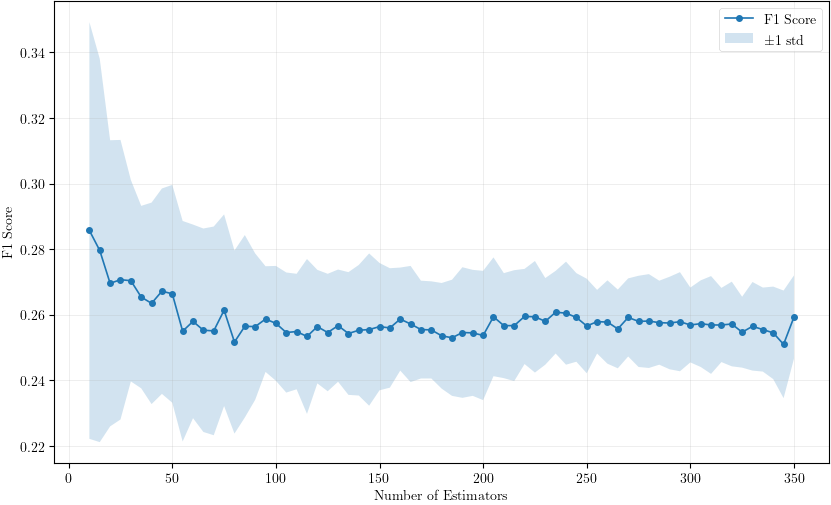

In [20]:
results_file = '../data/results/fault_n_estimators_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    fault_n_estimators = results['best_n_estimators']
    fault_n_estimators_results = results['avg_results']

    print(f"\nBest n_estimators: {fault_n_estimators}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(fault_n_estimators_results, 'F1_Score_mean', 'F1_Score_std', 'n_estimators', xlabel='Number of Estimators', ylabel='F1 Score', saveas='fault_n_estimators')
else:
    fault_n_estimators, fault_n_estimators_results = evaluate_n_estimators(X_train_fault, X_test_fault, y_test_fault, 350, save_results=results_file)


Best n_estimators: 20
F1 Score: 0.1379 ± 0.0419


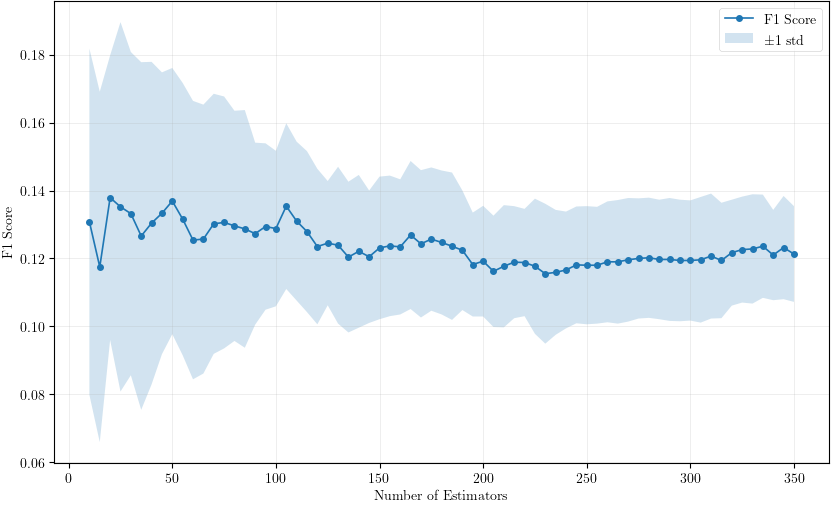

In [21]:
results_file = '../data/results/thyroid_n_estimators_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    thyroid_n_estimators = results['best_n_estimators']
    thyroid_n_estimators_results = results['avg_results']
  
    print(f"\nBest n_estimators: {thyroid_n_estimators}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(thyroid_n_estimators_results, 'F1_Score_mean', 'F1_Score_std', 'n_estimators', xlabel='Number of Estimators', ylabel='F1 Score', saveas='thyroid_n_estimators')
else:
    thyroid_n_estimators, thyroid_n_estimators_results = evaluate_n_estimators(X_train_thyroid, X_test_thyroid, y_test_thyroid, 350, save_results=results_file)


Best n_estimators: 330
F1 Score: 0.2137 ± 0.0122


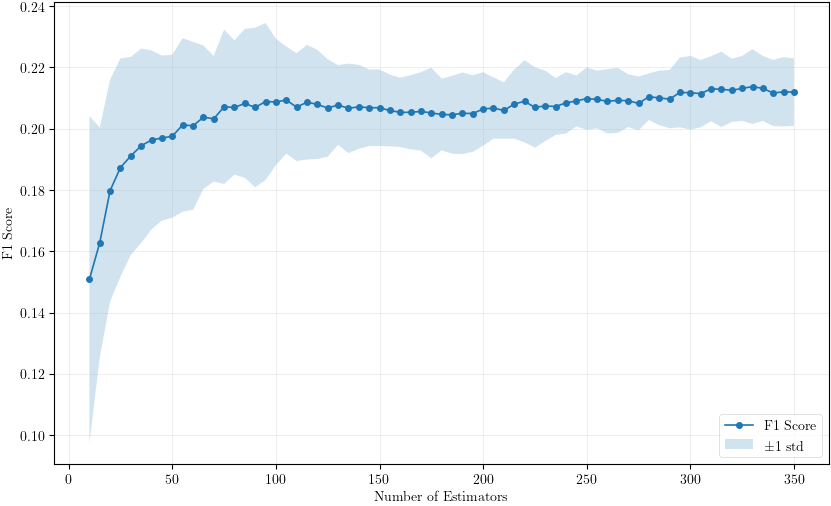

In [22]:
results_file = '../data/results/sat_n_estimators_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    sat_n_estimators = results['best_n_estimators']
    sat_n_estimators_results = results['avg_results']
    
    print(f"\nBest n_estimators: {sat_n_estimators}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(sat_n_estimators_results, 'F1_Score_mean', 'F1_Score_std', 'n_estimators', xlabel='Number of Estimators', ylabel='F1 Score', saveas='sat_n_estimators_sat')
else:
    sat_n_estimators, sat_n_estimators_results = evaluate_n_estimators(X_train_sat, X_test_sat, y_test_sat, 350, save_results=results_file)

#### Maximum samples

In [23]:
def evaluate_max_samples(X_train, X_test, y_test, start=4, stop=512, step=1, n_runs=10, save_results=None):
    """
    Evaluate max_samples parameter over multiple independent runs with different random states
    """
    all_results = []
    
    num_runs = tqdm.tqdm(range(n_runs), desc="Maximum Samples")
    for run in num_runs:
        results = []
        
        for max_samples in range(start, stop + 1, step):
            model = IsolationForest(max_samples=max_samples, random_state=42 + run)
            model.fit(X_train)
            y_pred = model.predict(X_test)
            y_pred = np.where(y_pred == 1, 0, 1)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            anomaly_pred_pct = np.mean(y_pred) * 100
            anomaly_true_pct = np.mean(y_test) * 100
            
            results.append({
                'max_samples': max_samples,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'MCC': mcc,
                'AUC': auc,
                'Anomaly_Pred_Percentage': anomaly_pred_pct,
                'Anomaly_True_Percentage': anomaly_true_pct
            })

        all_results.extend(results)

    all_results_df = pd.DataFrame(all_results)

    # Calculate averages and standard deviations
    avg_results = all_results_df.groupby('max_samples').agg({
        'Accuracy': ['mean', 'std'],
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1_Score': ['mean', 'std'],
        'MCC': ['mean', 'std'],
        'AUC': ['mean', 'std'],
        'Anomaly_Pred_Percentage': ['mean', 'std'],
        'Anomaly_True_Percentage': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
    avg_results.reset_index(inplace=True)
    
    # Find best parameter based on average F1 score
    best_idx = avg_results['F1_Score_mean'].idxmax()
    best_max_samples = avg_results.loc[best_idx, 'max_samples']
    best_avg_f1 = avg_results.loc[best_idx, 'F1_Score_mean']
    best_std_f1 = avg_results.loc[best_idx, 'F1_Score_std']

    print(f"\nBest max_samples: {best_max_samples}")
    print(f"Average F1 Score: {best_avg_f1:.4f} ± {best_std_f1:.4f}")

    # plot results
    plot_results(avg_results, 'F1_Score_mean', 'F1_Score_std', 'max_samples', xlabel='Max Samples', ylabel='F1 Score')

    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump({
                'all_results_df': all_results_df,
                'avg_results': avg_results,
                'best_max_samples': best_max_samples,
                'best_avg_f1': best_avg_f1,
                'best_std_f1': best_std_f1
            }, f)
    
    return best_max_samples, avg_results


Best max_samples: 11
F1 Score: 0.4115 ± 0.0315


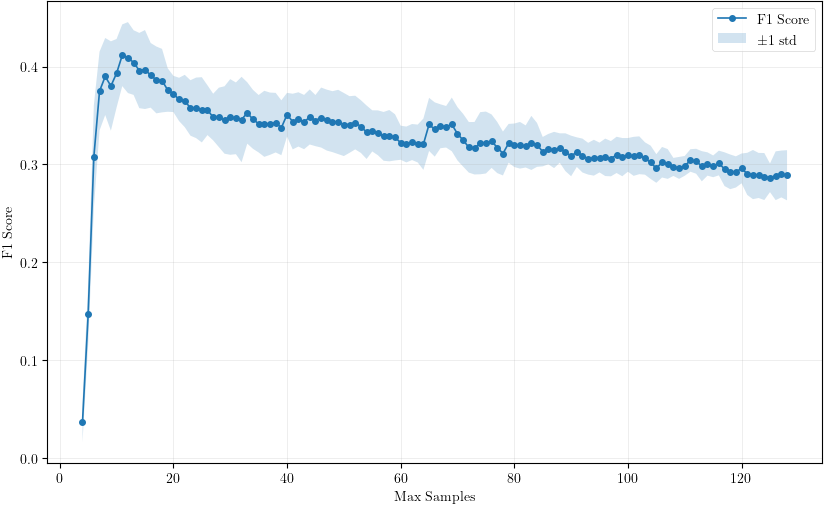

In [24]:
results_file = '../data/results/fault_max_samples_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    fault_max_samples = results['best_max_samples']
    fault_max_samples_results = results['avg_results']
    
    print(f"\nBest max_samples: {fault_max_samples}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(fault_max_samples_results, 'F1_Score_mean', 'F1_Score_std', 'max_samples', xlabel='Max Samples', ylabel='F1 Score', saveas='fault_max_samples')
else:
    fault_max_samples, fault_max_samples_results = evaluate_max_samples(X_train_fault, X_test_fault, y_test_fault, 4, 128, 1, save_results=results_file)


Best max_samples: 45
F1 Score: 0.1698 ± 0.0238


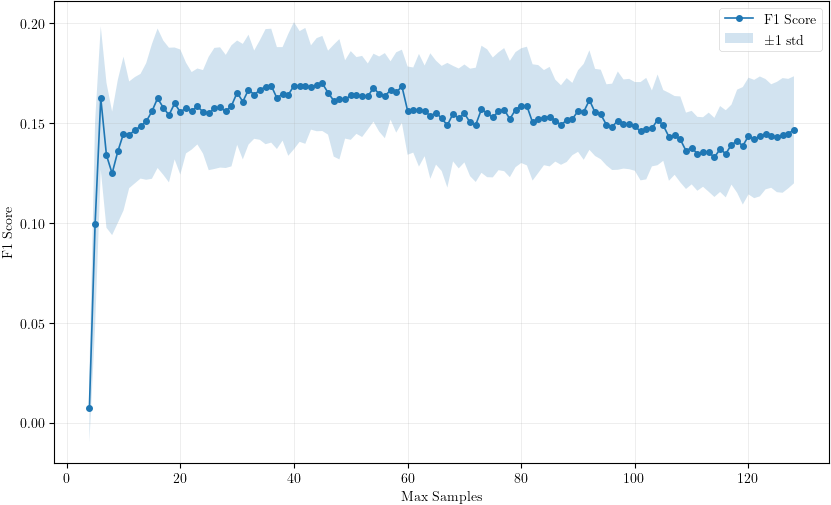

In [25]:
results_file = '../data/results/thyroid_max_samples_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    thyroid_max_samples = results['best_max_samples']
    thyroid_max_samples_results = results['avg_results']
    
    print(f"\nBest max_samples: {thyroid_max_samples}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(thyroid_max_samples_results, 'F1_Score_mean', 'F1_Score_std', 'max_samples', xlabel='Max Samples', ylabel='F1 Score', saveas='thyroid_max_samples')
else:
    thyroid_max_samples, thyroid_max_samples_results = evaluate_max_samples(X_train_thyroid, X_test_thyroid, y_test_thyroid, start=4, stop=128, step=1, save_results=results_file)


Best max_samples: 1962
F1 Score: 0.3931 ± 0.0238


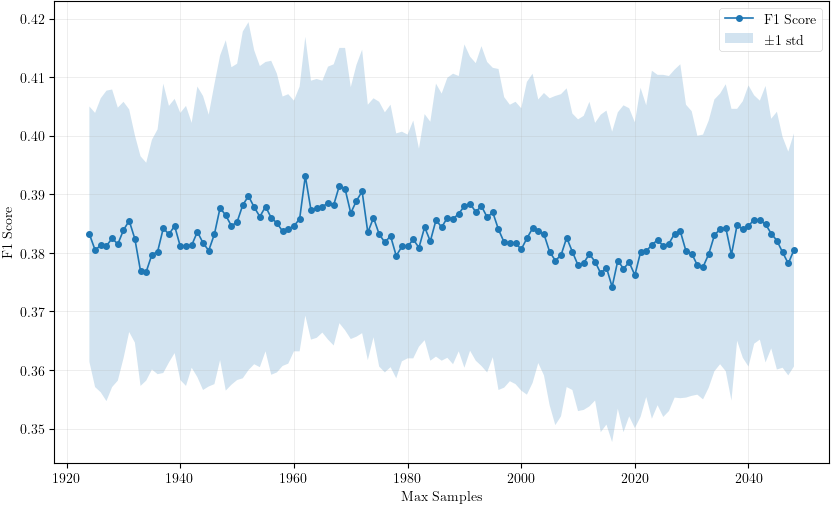

In [26]:
results_file = '../data/results/sat_max_samples_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    sat_max_samples = results['best_max_samples']
    sat_max_samples_results = results['avg_results']
    
    print(f"\nBest max_samples: {sat_max_samples}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(sat_max_samples_results, 'F1_Score_mean', 'F1_Score_std', 'max_samples', xlabel='Max Samples', ylabel='F1 Score', saveas='sat_max_samples')
else:
    sat_max_samples, sat_max_samples_results = evaluate_max_samples(X_train_sat, X_test_sat, y_test_sat, start=1924, stop=2048, step=1, save_results=results_file)

#### Maximum features

In [27]:
def evaluate_max_features(X_train, X_test, y_test, n_runs=10, save_results=None):
    """
    Evaluate max_features parameter over multiple independent runs with different random states
    """
    all_results = []
    
    num_runs = tqdm.tqdm(range(n_runs), desc="Maximum Features")
    for run in num_runs:
        results = []
        
        max_features_range = X_train.shape[1]
        for max_features in range(1, max_features_range + 1):
            model = IsolationForest(max_features=max_features, random_state=42 + run)
            model.fit(X_train)
            y_pred = model.predict(X_test)
            y_pred = np.where(y_pred == 1, 0, 1)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            anomaly_pred_pct = np.mean(y_pred) * 100
            anomaly_true_pct = np.mean(y_test) * 100
            
            results.append({
                'max_features': max_features,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'MCC': mcc,
                'AUC': auc,
                'Anomaly_Pred_Percentage': anomaly_pred_pct,
                'Anomaly_True_Percentage': anomaly_true_pct
            })

        all_results.extend(results)

    all_results_df = pd.DataFrame(all_results)

    # Calculate averages and standard deviations
    avg_results = all_results_df.groupby('max_features').agg({
        'Accuracy': ['mean', 'std'],
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1_Score': ['mean', 'std'],
        'MCC': ['mean', 'std'],
        'AUC': ['mean', 'std'],
        'Anomaly_Pred_Percentage': ['mean', 'std'],
        'Anomaly_True_Percentage': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
    avg_results.reset_index(inplace=True)
    
    # Find best parameter based on average F1 score
    best_idx = avg_results['F1_Score_mean'].idxmax()
    best_max_features = avg_results.loc[best_idx, 'max_features']
    best_avg_f1 = avg_results.loc[best_idx, 'F1_Score_mean']
    best_std_f1 = avg_results.loc[best_idx, 'F1_Score_std']

    print(f"\nBest max_features: {best_max_features}")
    print(f"Average F1 Score: {best_avg_f1:.4f} ± {best_std_f1:.4f}")

    # plot results
    plot_results(avg_results, 'F1_Score_mean', 'F1_Score_std', 'max_features', xlabel='Max Features', ylabel='F1 Score')

    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump({
                'all_results_df': all_results_df,
                'avg_results': avg_results,
                'best_max_features': best_max_features,
                'best_avg_f1': best_avg_f1,
                'best_std_f1': best_std_f1
            }, f)

    return best_max_features, avg_results


Best max_features: 16
F1 Score: 0.2799 ± 0.0229


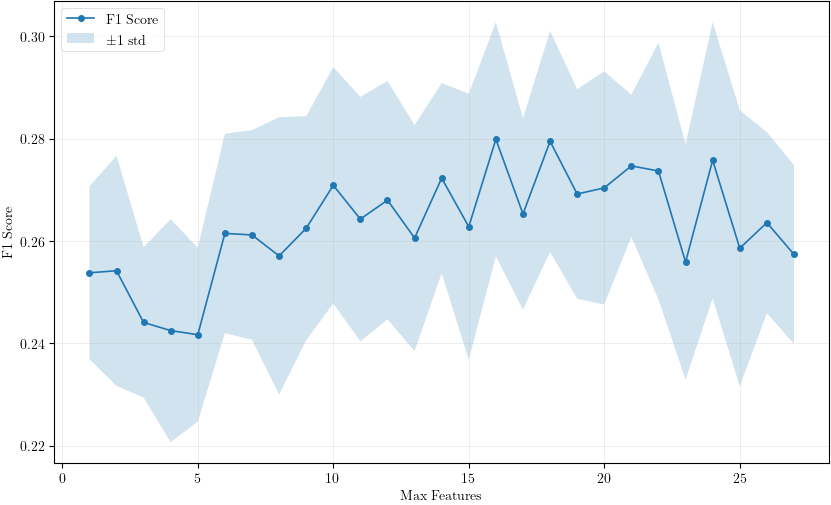

In [28]:
results_file = '../data/results/fault_max_features_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    fault_max_features = results['best_max_features']
    fault_max_features_results = results['avg_results']

    print(f"\nBest max_features: {fault_max_features}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(fault_max_features_results, 'F1_Score_mean', 'F1_Score_std', 'max_features', xlabel='Max Features', ylabel='F1 Score', saveas='fault_max_features')
else:
    fault_max_features, fault_max_features_results = evaluate_max_features(X_train_fault, X_test_fault, y_test_fault, save_results=results_file)


Best max_features: 2
F1 Score: 0.2347 ± 0.0523


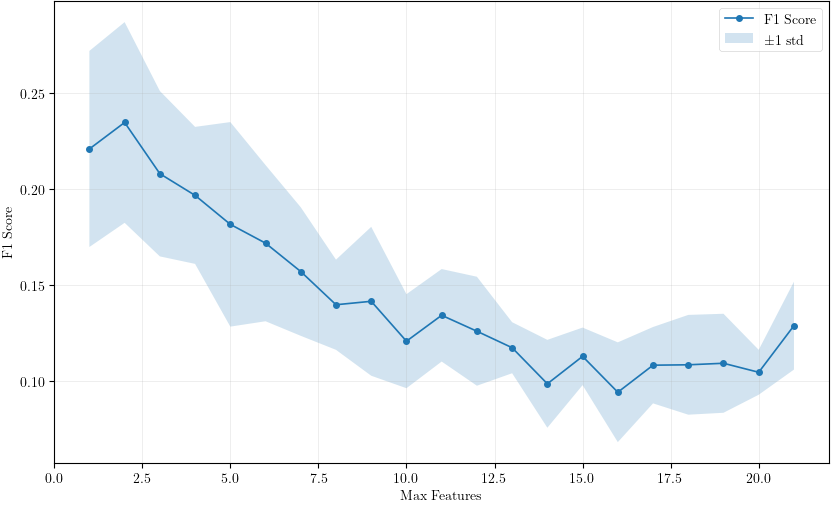

In [29]:
results_file = '../data/results/thyroid_max_features_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    thyroid_max_features = results['best_max_features']
    thyroid_max_features_results = results['avg_results']

    print(f"\nBest max_features: {thyroid_max_features}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(thyroid_max_features_results, 'F1_Score_mean', 'F1_Score_std', 'max_features', xlabel='Max Features', ylabel='F1 Score', saveas='thyroid_max_features')
else:
    thyroid_max_features, thyroid_max_features_results = evaluate_max_features(X_train_thyroid, X_test_thyroid, y_test_thyroid, save_results=results_file)


Best max_features: 21
F1 Score: 0.2104 ± 0.0189


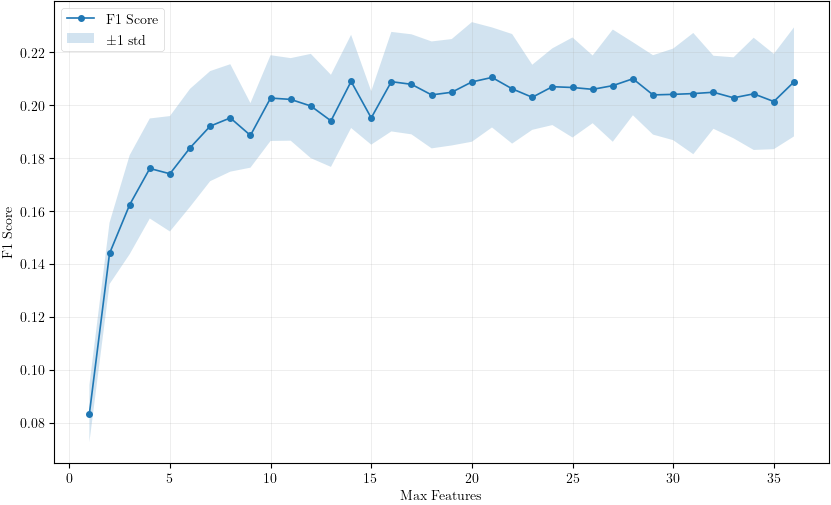

In [30]:
results_file = '../data/results/sat_max_features_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    sat_max_features = results['best_max_features']
    sat_max_features_results = results['avg_results']

    print(f"\nBest max_features: {sat_max_features}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")
    
    # plot results
    plot_results(sat_max_features_results, 'F1_Score_mean', 'F1_Score_std', 'max_features', xlabel='Max Features', ylabel='F1 Score', saveas='sat_max_features')
else:
    sat_max_features, sat_max_features_results = evaluate_max_features(X_train_sat, X_test_sat, y_test_sat, save_results=results_file)

#### Contamination

In [31]:
def evaluate_contamination(X_train, X_test, y_test, start=0.01, stop=0.5, step=0.01, n_runs=10, save_results=None):
    """
    Evaluate contamination parameter over multiple independent runs with different random states
    """
    all_results = []

    num_runs = tqdm.tqdm(range(n_runs), desc="Contamination")
    for run in num_runs:
        results = []
        
        contamination_values = np.arange(start, stop + step, step)
        contamination_values = np.round(contamination_values, 3)  # round to avoid floating point issues
        for contamination in contamination_values:
            model = IsolationForest(contamination=contamination, random_state=42 + run)
            model.fit(X_train)
            y_pred = model.predict(X_test)
            y_pred = np.where(y_pred == 1, 0, 1)  # convert to 0 (inlier) and 1 (outlier)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            anomaly_pred_pct = np.mean(y_pred) * 100
            anomaly_true_pct = np.mean(y_test) * 100
            
            results.append({
                'contamination': contamination,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1_Score': f1,
                'MCC': mcc,
                'AUC': auc,
                'Anomaly_Pred_Percentage': anomaly_pred_pct,
                'Anomaly_True_Percentage': anomaly_true_pct
            })

        all_results.extend(results)

    all_results_df = pd.DataFrame(all_results)

    # Calculate averages and standard deviations
    avg_results = all_results_df.groupby('contamination').agg({
        'Accuracy': ['mean', 'std'],
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1_Score': ['mean', 'std'],
        'MCC': ['mean', 'std'],
        'AUC': ['mean', 'std'],
        'Anomaly_Pred_Percentage': ['mean', 'std'],
        'Anomaly_True_Percentage': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
    avg_results.reset_index(inplace=True)
    
    # Find best parameter based on average F1 score
    best_idx = avg_results['F1_Score_mean'].idxmax()
    best_contamination = avg_results.loc[best_idx, 'contamination']
    best_avg_f1 = avg_results.loc[best_idx, 'F1_Score_mean']
    best_std_f1 = avg_results.loc[best_idx, 'F1_Score_std']

    print(f"\nBest contamination: {best_contamination}")
    print(f"Average F1 Score: {best_avg_f1:.4f} ± {best_std_f1:.4f}")

    # plot results
    plot_results(avg_results, 'F1_Score_mean', 'F1_Score_std', 'contamination', xlabel='Contamination', ylabel='F1 Score')

    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump({
                'all_results_df': all_results_df,
                'avg_results': avg_results,
                'best_contamination': best_contamination,
                'best_avg_f1': best_avg_f1,
                'best_std_f1': best_std_f1
            }, f)

    return best_contamination, avg_results


Best contamination: 0.5
F1 Score: 0.4416 ± 0.0197


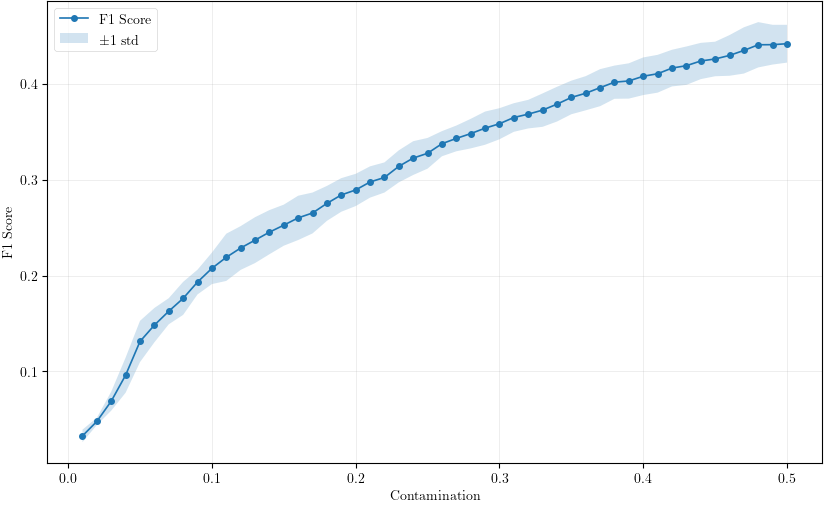

In [32]:
results_file = '../data/results/fault_contamination_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    fault_contamination = results['best_contamination']
    fault_contamination_results = results['avg_results']

    print(f"\nBest contamination: {fault_contamination}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")

    # plot results
    plot_results(fault_contamination_results, 'F1_Score_mean', 'F1_Score_std', 'contamination', xlabel='Contamination', ylabel='F1 Score', saveas='fault_contamination')
else:
    fault_contamination, fault_contamination_results = evaluate_contamination(X_train_fault, X_test_fault, y_test_fault, start=0.01, stop=0.5, step=0.01, save_results=results_file)


Best contamination: 0.05
F1 Score: 0.1306 ± 0.0242


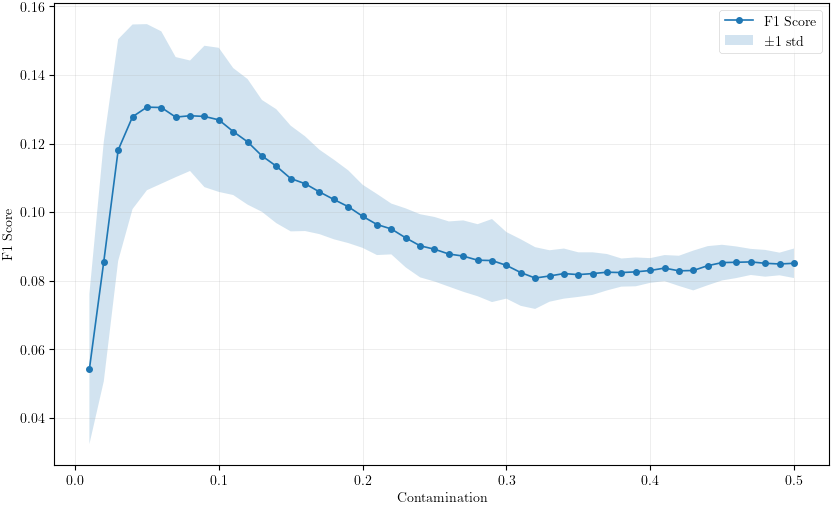

In [33]:
results_file = '../data/results/thyroid_contamination_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    thyroid_contamination = results['best_contamination']
    thyroid_contamination_results = results['avg_results']
    
    print(f"\nBest contamination: {thyroid_contamination}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")

    # plot results
    plot_results(thyroid_contamination_results, 'F1_Score_mean', 'F1_Score_std', 'contamination', xlabel='Contamination', ylabel='F1 Score', saveas='thyroid_contamination')
else:
    thyroid_contamination, thyroid_contamination_results = evaluate_contamination(X_train_thyroid, X_test_thyroid, y_test_thyroid, start=0.01, stop=0.5, step=0.01, save_results=results_file)


Best contamination: 0.011
F1 Score: 0.8690 ± 0.0328


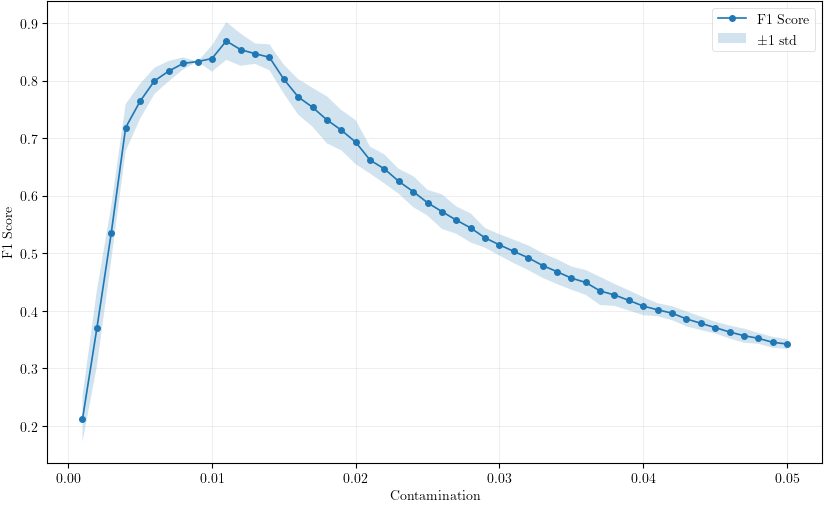

In [34]:
results_file = '../data/results/sat_contamination_results.pkl'

# first try load results
if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    sat_contamination = results['best_contamination']
    sat_contamination_results = results['avg_results']

    print(f"\nBest contamination: {sat_contamination}")
    print(f"F1 Score: {results['best_avg_f1']:.4f} ± {results['best_std_f1']:.4f}")

    # plot results
    plot_results(sat_contamination_results, 'F1_Score_mean', 'F1_Score_std', 'contamination', xlabel='Contamination', ylabel='F1 Score', saveas='sat_contamination')
else:
    sat_contamination, sat_contamination_results = evaluate_contamination(X_train_sat, X_test_sat, y_test_sat, start=0.001, stop=0.05, step=0.001, save_results=results_file)

### Determine the Sensitivity of the Isolation Forest to the Control Parameters

In [35]:
def evaluate_baseline(X_train, X_test, y_test, n_runs=10):
    """
    Evaluate baseline Isolation Forest with default parameters over multiple independent runs
    """
    all_results = []
    
    num_runs = tqdm.tqdm(range(n_runs), desc="Baseline Evaluation")
    for run in num_runs:
        model = IsolationForest(random_state=42 + run)
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = np.where(y_pred == 1, 0, 1)  # convert to 0 (inlier) and 1 (outlier)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        anomaly_pred_pct = np.mean(y_pred) * 100
        anomaly_true_pct = np.mean(y_test) * 100
        
        all_results.append({
            'run': run,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'MCC': mcc,
            'AUC': auc,
            'Anomaly_Pred_Percentage': anomaly_pred_pct,
            'Anomaly_True_Percentage': anomaly_true_pct
        })

    all_results_df = pd.DataFrame(all_results)

    # Calculate averages and standard deviations
    avg_results = all_results_df.agg({
        'Accuracy': ['mean', 'std'],
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1_Score': ['mean', 'std'],
        'MCC': ['mean', 'std'],
        'AUC': ['mean', 'std'],
        'Anomaly_Pred_Percentage': ['mean', 'std'],
        'Anomaly_True_Percentage': ['mean', 'std']
    }).round(4).T
    
    avg_results.columns = ['Mean', 'Std Dev']

    return avg_results

In [36]:
# Evaluate steel faults baseline results for 10 independent runs
fault_baseline_results = evaluate_baseline(X_train_fault, X_test_fault, y_test_fault)
print(fault_baseline_results)

Baseline Evaluation: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]

                            Mean  Std Dev
Accuracy                  0.6353   0.0119
Precision                 0.4399   0.0346
Recall                    0.1827   0.0172
F1_Score                  0.2574   0.0175
MCC                       0.0793   0.0265
AUC                       0.5290   0.0091
Anomaly_Pred_Percentage  14.4768   1.8654
Anomaly_True_Percentage  34.6484   0.0000


In [37]:
# Evaluate thyroid baseline results
thyroid_baseline_results = evaluate_baseline(X_train_thyroid, X_test_thyroid, y_test_thyroid)
print(thyroid_baseline_results)

Baseline Evaluation: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]

                           Mean  Std Dev
Accuracy                 0.9295   0.0039
Precision                0.1169   0.0223
Recall                   0.1440   0.0250
F1_Score                 0.1288   0.0229
MCC                      0.0932   0.0242
AUC                      0.5515   0.0130
Anomaly_Pred_Percentage  4.4771   0.3581
Anomaly_True_Percentage  3.6145   0.0000


In [38]:
# Evaluate satimage baseline results
sat_baseline_results = evaluate_baseline(X_train_sat, X_test_sat, y_test_sat)
print(sat_baseline_results)

Baseline Evaluation: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]

                            Mean  Std Dev
Accuracy                  0.9096   0.0119
Precision                 0.1170   0.0131
Recall                    0.9762   0.0251
F1_Score                  0.2087   0.0206
MCC                       0.3209   0.0186
AUC                       0.9425   0.0104
Anomaly_Pred_Percentage  10.1838   1.2266
Anomaly_True_Percentage   1.2062   0.0000


In [39]:
def evaluate_sensitivity(baseline_results, n_estimator_results, max_samples_results, max_features_results, contamination_results, best_n_est, best_max_samp, best_max_feat, best_contam):
    """
    Evaluate sensitivity of each control parameter by comparing baseline vs optimized performance
    """
    
    # Extract baseline performance (mean values)
    baseline_metrics = {
        'Accuracy': baseline_results.loc['Accuracy', 'Mean'],
        'Precision': baseline_results.loc['Precision', 'Mean'],
        'Recall': baseline_results.loc['Recall', 'Mean'],
        'F1_Score': baseline_results.loc['F1_Score', 'Mean'],
        'MCC': baseline_results.loc['MCC', 'Mean'],
        'AUC': baseline_results.loc['AUC', 'Mean']
    }
    
    # Extract best performance for each parameter
    best_n_est_metrics = {
        'Accuracy': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['Accuracy_mean'].iloc[0],
        'Precision': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['Precision_mean'].iloc[0],
        'Recall': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['Recall_mean'].iloc[0],
        'F1_Score': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['F1_Score_mean'].iloc[0],
        'MCC': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['MCC_mean'].iloc[0],
        'AUC': n_estimator_results[n_estimator_results['n_estimators'] == best_n_est]['AUC_mean'].iloc[0]
    }
    
    best_max_samp_metrics = {
        'Accuracy': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['Accuracy_mean'].iloc[0],
        'Precision': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['Precision_mean'].iloc[0],
        'Recall': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['Recall_mean'].iloc[0],
        'F1_Score': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['F1_Score_mean'].iloc[0],
        'MCC': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['MCC_mean'].iloc[0],
        'AUC': max_samples_results[max_samples_results['max_samples'] == best_max_samp]['AUC_mean'].iloc[0]
    }
    
    best_max_feat_metrics = {
        'Accuracy': max_features_results[max_features_results['max_features'] == best_max_feat]['Accuracy_mean'].iloc[0],
        'Precision': max_features_results[max_features_results['max_features'] == best_max_feat]['Precision_mean'].iloc[0],
        'Recall': max_features_results[max_features_results['max_features'] == best_max_feat]['Recall_mean'].iloc[0],
        'F1_Score': max_features_results[max_features_results['max_features'] == best_max_feat]['F1_Score_mean'].iloc[0],
        'MCC': max_features_results[max_features_results['max_features'] == best_max_feat]['MCC_mean'].iloc[0],
        'AUC': max_features_results[max_features_results['max_features'] == best_max_feat]['AUC_mean'].iloc[0]
    }
    
    best_contam_metrics = {
        'Accuracy': contamination_results[contamination_results['contamination'] == best_contam]['Accuracy_mean'].iloc[0],
        'Precision': contamination_results[contamination_results['contamination'] == best_contam]['Precision_mean'].iloc[0],
        'Recall': contamination_results[contamination_results['contamination'] == best_contam]['Recall_mean'].iloc[0],
        'F1_Score': contamination_results[contamination_results['contamination'] == best_contam]['F1_Score_mean'].iloc[0],
        'MCC': contamination_results[contamination_results['contamination'] == best_contam]['MCC_mean'].iloc[0],
        'AUC': contamination_results[contamination_results['contamination'] == best_contam]['AUC_mean'].iloc[0]
    }
    
    # Calculate improvements (absolute differences)
    parameters = ['n_estimators', 'max_samples', 'max_features', 'contamination']
    best_metrics = [best_n_est_metrics, best_max_samp_metrics, best_max_feat_metrics, best_contam_metrics]
    
    sensitivity_results = []
    
    for param, best_metric in zip(parameters, best_metrics):
        param_sensitivity = {'Parameter': param}
        
        for metric in baseline_metrics.keys():
            improvement = abs(best_metric[metric] - baseline_metrics[metric])
            param_sensitivity[f'{metric}_Improvement'] = improvement
        
        # Calculate average improvement across all metrics
        avg_improvement = np.mean([param_sensitivity[f'{metric}_Improvement'] for metric in baseline_metrics.keys()])
        param_sensitivity['Average_Improvement'] = avg_improvement
        
        sensitivity_results.append(param_sensitivity)
    
    # Convert to DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    # Rank parameters by average improvement (highest = most sensitive)
    sensitivity_df = sensitivity_df.sort_values('Average_Improvement', ascending=False)
    sensitivity_df['Sensitivity_Rank'] = range(1, len(sensitivity_df) + 1)
    
    return sensitivity_df

def plot_sensitivity_analysis(sensitivity_df, dataset_name, saveas=None):
    """
    Plot sensitivity analysis results
    """
    metrics = ['Accuracy_Improvement', 'Precision_Improvement', 'Recall_Improvement', 
               'F1_Score_Improvement', 'MCC_Improvement', 'AUC_Improvement']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Heatmap of improvements
    improvement_matrix = sensitivity_df[metrics].values
    parameters = sensitivity_df['Parameter'].values
    
    im = ax1.imshow(improvement_matrix, cmap='Blues', aspect='auto')
    ax1.set_xticks(range(len(metrics)))
    ax1.set_xticklabels([m.replace('_Improvement', '') for m in metrics], rotation=45)
    ax1.set_yticks(range(len(parameters)))
    ax1.set_yticklabels(parameters)
    ax1.set_title(f'{dataset_name}: Parameter Sensitivity Heatmap')
    
    # Add text annotations
    for i in range(len(parameters)):
        for j in range(len(metrics)):
            text = ax1.text(j, i, f'{improvement_matrix[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=ax1, label='Improvement')
    
    # Plot 2: Average improvement ranking
    ax2.barh(range(len(parameters)), sensitivity_df['Average_Improvement'], 
             color=['red', 'orange', 'yellow', 'green'])
    ax2.set_yticks(range(len(parameters)))
    ax2.set_yticklabels(parameters)
    ax2.set_xlabel('Average Improvement')
    ax2.set_title(f'{dataset_name}: Parameter Sensitivity Ranking')
    ax2.grid(True, alpha=0.3)
    
    # Add rank labels
    for i, (param, avg_imp, rank) in enumerate(zip(parameters, sensitivity_df['Average_Improvement'], 
                                                   sensitivity_df['Sensitivity_Rank'])):
        ax2.text(avg_imp + 0.001, i, f'Rank {rank}', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}_sensitivity.pdf", dpi=300, bbox_inches='tight')
    plt.show()

def compare_dataset_sensitivity(fault_sens, thyroid_sens, sat_sens):
    """
    Compare sensitivity across datasets
    """
    # Combine results
    fault_sens['Dataset'] = 'Steel Faults'
    thyroid_sens['Dataset'] = 'Thyroid'
    sat_sens['Dataset'] = 'Satimage-2'
    
    combined_df = pd.concat([fault_sens, thyroid_sens, sat_sens], ignore_index=True)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    metrics = ['Accuracy_Improvement', 'Precision_Improvement', 'Recall_Improvement', 
               'F1_Score_Improvement', 'MCC_Improvement', 'AUC_Improvement']
    
    for i, metric in enumerate(metrics):
        pivot_data = combined_df.pivot(index='Parameter', columns='Dataset', values=metric)
        pivot_data.plot(kind='bar', ax=axes[i], width=0.8)
        axes[i].set_title(metric.replace('_Improvement', ' Improvement'))
        axes[i].set_ylabel('Improvement')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.savefig("../report/plots/sensitivity_comparison_all_datasets.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_df

       Parameter  Average_Improvement  Sensitivity_Rank
1    max_samples             0.163233                 1
3  contamination             0.114783                 2
0   n_estimators             0.024033                 3
2   max_features             0.018367                 4


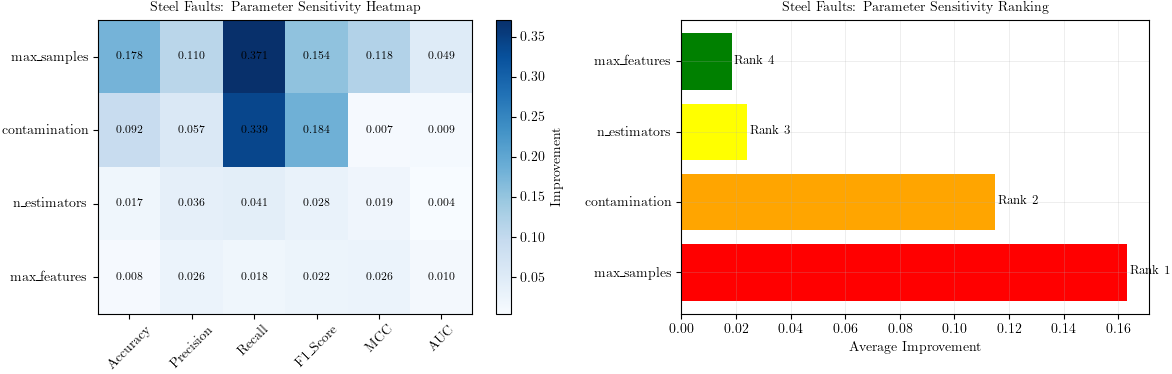

In [40]:
# Evaluate sensitivity for steel faults dataset
fault_sensitivity = evaluate_sensitivity(
    fault_baseline_results, 
    fault_n_estimators_results, 
    fault_max_samples_results, 
    fault_max_features_results, 
    fault_contamination_results,
    fault_n_estimators,
    fault_max_samples, 
    fault_max_features, 
    fault_contamination
)

print(fault_sensitivity[['Parameter', 'Average_Improvement', 'Sensitivity_Rank']])
plot_sensitivity_analysis(fault_sensitivity, 'Steel Faults', 'fault')

       Parameter  Average_Improvement  Sensitivity_Rank
2   max_features             0.082917                 1
1    max_samples             0.051967                 2
0   n_estimators             0.010117                 3
3  contamination             0.005900                 4


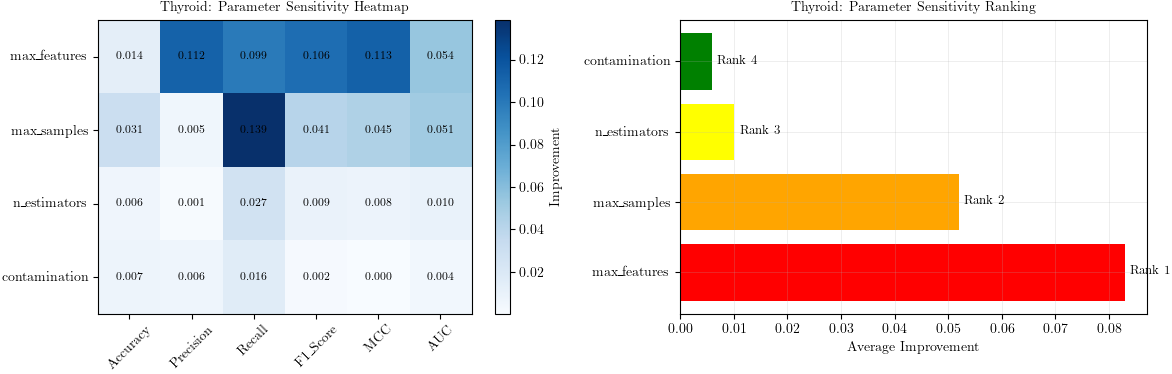

In [41]:
# Evaluate sensitivity for Thyroid dataset
thyroid_sensitivity = evaluate_sensitivity(
    thyroid_baseline_results, 
    thyroid_n_estimators_results, 
    thyroid_max_samples_results, 
    thyroid_max_features_results, 
    thyroid_contamination_results,
    thyroid_n_estimators,
    thyroid_max_samples, 
    thyroid_max_features, 
    thyroid_contamination
)

print(thyroid_sensitivity[['Parameter', 'Average_Improvement', 'Sensitivity_Rank']])
plot_sensitivity_analysis(thyroid_sensitivity, 'Thyroid', 'thyroid')

       Parameter  Average_Improvement  Sensitivity_Rank
3  contamination             0.387950                 1
1    max_samples             0.094117                 2
0   n_estimators             0.005800                 3
2   max_features             0.002233                 4


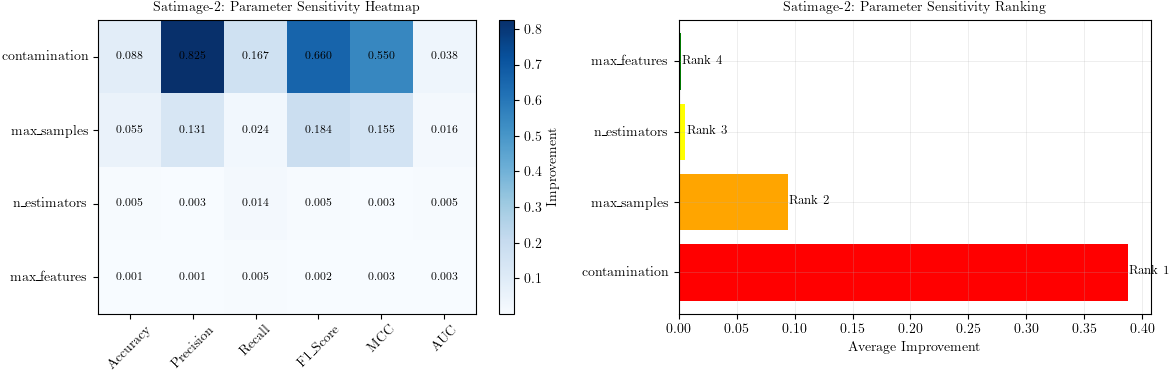

In [42]:
# Evaluate sensitivity for Satimage-2 dataset
sat_sensitivity = evaluate_sensitivity(
    sat_baseline_results, 
    sat_n_estimators_results, 
    sat_max_samples_results, 
    sat_max_features_results, 
    sat_contamination_results,
    sat_n_estimators,
    sat_max_samples, 
    sat_max_features, 
    sat_contamination
)

print(sat_sensitivity[['Parameter', 'Average_Improvement', 'Sensitivity_Rank']])
plot_sensitivity_analysis(sat_sensitivity, 'Satimage-2', 'satimage')

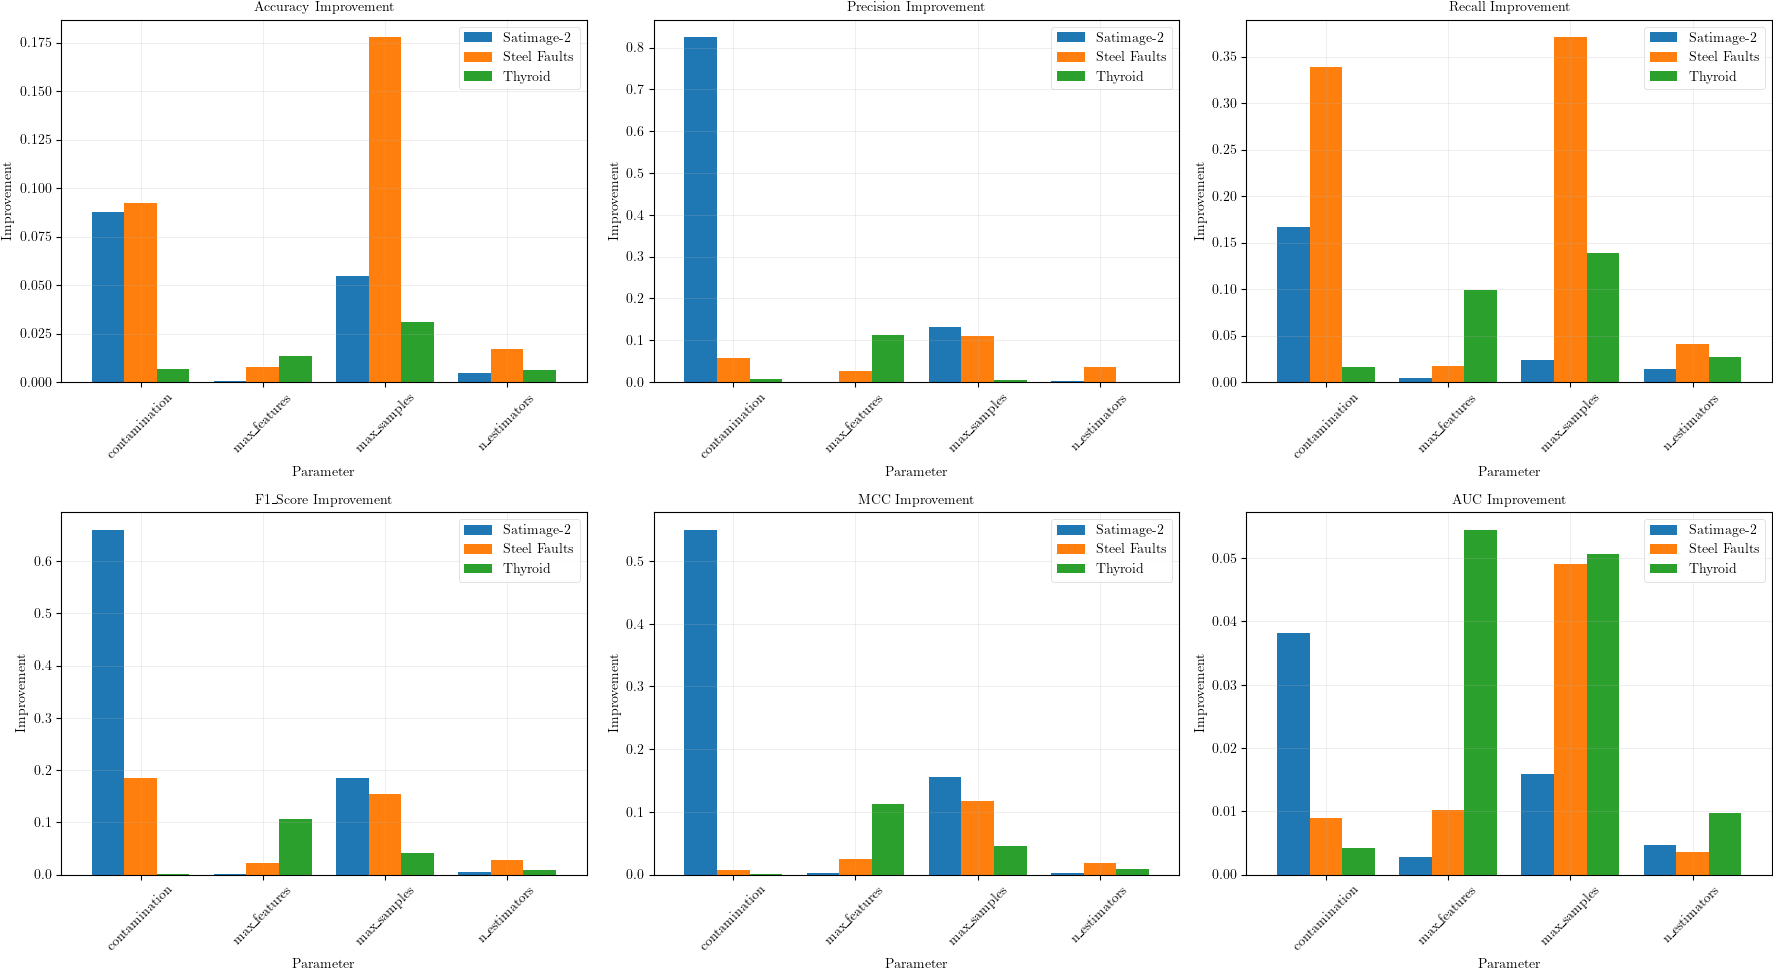

In [43]:
# Compare across datasets
combined_sensitivity = compare_dataset_sensitivity(fault_sensitivity, thyroid_sensitivity, sat_sensitivity)

In [44]:
parameters = ['n_estimators', 'max_samples', 'max_features', 'contamination']
datasets = ['Steel Faults', 'Thyroid', 'Satimage']
results = []

for param in parameters:
    fault_rank = fault_sensitivity[fault_sensitivity['Parameter'] == param]['Sensitivity_Rank'].iloc[0]
    thyroid_rank = thyroid_sensitivity[thyroid_sensitivity['Parameter'] == param]['Sensitivity_Rank'].iloc[0]
    sat_rank = sat_sensitivity[sat_sensitivity['Parameter'] == param]['Sensitivity_Rank'].iloc[0]

    avg_rank = np.mean([fault_rank, thyroid_rank, sat_rank])
    
    results.append({
        'Parameter': param,
        'Steel_Faults_Rank': fault_rank,
        'Thyroid_Rank': thyroid_rank,
        'Satimage_Rank': sat_rank,
        'Average_Rank': avg_rank
    })

# sort by average rank
avg_ranks_df = pd.DataFrame(results)
avg_ranks_df = avg_ranks_df.sort_values('Average_Rank')
avg_ranks_df['Final_Rank'] = range(1, len(avg_ranks_df) + 1)
for idx, row in avg_ranks_df.iterrows():
    print(f"{row['Final_Rank']}. {row['Parameter']}: Average Rank = {row['Average_Rank']:.2f}")

1. max_samples: Average Rank = 1.67
2. contamination: Average Rank = 2.33
3. n_estimators: Average Rank = 3.00
4. max_features: Average Rank = 3.00


### Control Parameter Correlation

Likely correlations to test

- max_samples vs n_estimators: smaller max_samples may need more n_estimators to stabilize detection.

- max_features vs dataset dimensionality: high-dim noisy features → lower max_features helps.

- contamination vs observed precision/recall: higher contamination → more positive predictions → recall ↑, precision ↓.

Guidelines to derive

- If anomalies are sparse and subtle → use larger max_samples (to let trees see enough structure) and moderate n_estimators.

- If anomalies are strong single-point outliers → smaller max_samples may isolate them faster (but validate for variance).

- For noisy high-dim data → lower max_features or feature selection prior to IF.

- Use n_estimators large enough to stabilize scores (check std of metric), but stop when marginal gain is tiny.

- If contamination is unknown, evaluate on score metrics (AUC/AP) and avoid hard thresholding without validation.

## Thoughts:
- [DONE] sample the 5-10 parameter values before the best control parameter and use this to evaluate different models to investigate the effect on performance
- [MAYBE] use all / many values and create a large heat map
- [TODO] calculate the correlation between the interactions of the parameter values and the f1 mean scores

In [45]:
print(fault_max_samples_results.shape)
print(fault_max_features_results.shape)
print(fault_contamination_results.shape)
fault_n_estimators_results.head()

(125, 17)
(27, 17)
(50, 17)


,n_estimators,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_Score_mean,F1_Score_std,MCC_mean,MCC_std,AUC_mean,AUC_std,Anomaly_Pred_Percentage_mean,Anomaly_Pred_Percentage_std,Anomaly_True_Percentage_mean,Anomaly_True_Percentage_std
0,10,0.6182,0.0239,0.4042,0.0648,0.2233,0.0641,0.2857,0.0635,0.0604,0.0698,0.5254,0.0303,19.0051,3.4303,34.6484,0.0
1,15,0.6209,0.0240,0.4102,0.0662,0.2149,0.0554,0.2796,0.0584,0.0629,0.0646,0.5255,0.0264,18.1475,3.6474,34.6484,0.0
2,20,0.6297,0.0202,0.4280,0.0543,0.1985,0.0388,0.2696,0.0436,0.0740,0.0510,0.5284,0.0202,16.1407,2.8340,34.6484,0.0
3,25,0.6322,0.0177,0.4331,0.0531,0.1980,0.0361,0.2707,0.0426,0.0788,0.0490,0.5302,0.0190,15.8491,2.2830,34.6484,0.0
4,30,0.6312,0.0202,0.4338,0.0554,0.1975,0.0249,0.2704,0.0307,0.0777,0.0482,0.5293,0.0180,15.9177,2.2580,34.6484,0.0


In [46]:
print(thyroid_n_estimators_results.shape)
print(thyroid_max_samples_results.shape)
print(thyroid_max_features_results.shape)
print(thyroid_contamination_results.shape)

(69, 17)
(125, 17)
(21, 17)
(50, 17)


In [47]:
print(sat_n_estimators_results.shape)
print(sat_max_samples_results.shape)
print(sat_max_features_results.shape)
print(sat_contamination_results.shape)

(69, 17)
(125, 17)
(36, 17)
(50, 17)


In [48]:
def sample_best_params(param_results, best_param, n_samples=5):
    """
    Sample a few values around the best parameter for interaction evaluation
    """
    param_values = np.sort(param_results)
    
    # find index of best parameter
    best_idx = np.where(param_values == best_param)[0][0]

    # account for no previous or next values
    if best_idx == 0:
        return param_values[:n_samples + 1]
    if best_idx == len(param_values) - 1:
        return param_values[-n_samples - 1:]
    
    # Determine range to sample around best parameter
    start_idx = max(0, best_idx - n_samples // 2)
    end_idx = min(len(param_values), best_idx + n_samples // 2 + 1)
    
    sampled_values = param_values[start_idx:end_idx]
    
    return sampled_values

def evaluate_interactions(X_train, X_test, y_test, n_estimator_results, max_samples_results, 
                          max_features_results, contamination_results, best_n_est, best_max_samp, 
                          best_max_feat, best_contam, n_runs=5, save_results=None):
    """
    Evaluate parameter interactions for all pairwise combinations of control parameters
    """
    parameters = {
        'n_estimators': n_estimator_results,
        'max_samples': max_samples_results,
        'max_features': max_features_results,
        'contamination': contamination_results
    }
    
    best_values = {
        'n_estimators': best_n_est,
        'max_samples': best_max_samp,
        'max_features': best_max_feat,
        'contamination': best_contam
    }
    
    param_combinations = list(combinations(parameters.keys(), 2))
    interaction_results = {}
    
    for param1, param2 in param_combinations:
        print(f"\nEvaluating interaction: {param1} vs {param2}")
        
        # Get parameter value ranges
        param1_values = parameters[param1][param1].unique()
        param2_values = parameters[param2][param2].unique()
        param1_values = sample_best_params(param1_values, best_values[param1], n_samples=8)
        param2_values = sample_best_params(param2_values, best_values[param2], n_samples=8)

        print(f"Testing {len(param1_values)} x {len(param2_values)} combinations")
        
        all_results = []
        
        # Evaluate all combinations
        for run in tqdm.tqdm(range(n_runs), desc=f"Runs for {param1} vs {param2}"):
            for val1 in param1_values:
                for val2 in param2_values:
                    try:
                        # default model params
                        model_params = {
                            'n_estimators': 100,
                            'max_samples': 'auto',
                            'max_features': 1.0,
                            'contamination': 'auto',
                            'random_state': 42 + run
                        }

                        # override with param values
                        model_params[param1] = val1
                        model_params[param2] = val2
                        
                        model = IsolationForest(**model_params)
                        model.fit(X_train)
                        y_pred = model.predict(X_test)
                        y_pred = np.where(y_pred == 1, 0, 1)
                        
                        # Calculate metrics
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        mcc = matthews_corrcoef(y_test, y_pred)
                        auc = roc_auc_score(y_test, y_pred)
                        
                        all_results.append({
                            'run': run,
                            param1: val1,
                            param2: val2,
                            'Accuracy': accuracy,
                            'Precision': precision,
                            'Recall': recall,
                            'F1_Score': f1,
                            'MCC': mcc,
                            'AUC': auc
                        })
                        
                    except Exception as e:
                        print(f"Error with {param1}={val1}, {param2}={val2}: {e}")
                        continue
        
        # Convert to DataFrame and calculate averages
        results_df = pd.DataFrame(all_results)
        
        if len(results_df) > 0:
            avg_results = results_df.groupby([param1, param2]).agg({
                'Accuracy': ['mean', 'std'],
                'Precision': ['mean', 'std'],
                'Recall': ['mean', 'std'],
                'F1_Score': ['mean', 'std'],
                'MCC': ['mean', 'std'],
                'AUC': ['mean', 'std']
            }).round(4)
            
            avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns.values]
            avg_results.reset_index(inplace=True)
            
            interaction_results[f"{param1}_vs_{param2}"] = {
                'all_results': results_df,
                'avg_results': avg_results,
                'param1': param1,
                'param2': param2,
                'param1_values': param1_values,
                'param2_values': param2_values,
                'best_values': best_values
            }
        
    if save_results:
        with open(save_results, 'wb') as f:
            pickle.dump(interaction_results, f)
    
    return interaction_results

def plot_parameter_interactions(interaction_results, dataset_name, metric='F1_Score', saveas=None):
    """
    Plot heatmaps for all parameter interactions
    """
    n_interactions = len(interaction_results)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_interactions + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Ensure axes is always 2D array
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    interaction_items = list(interaction_results.items())
    
    for idx, (interaction_name, data) in enumerate(interaction_items):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        param1 = data['param1']
        param2 = data['param2']
        avg_results = data['avg_results']
        best_values = data['best_values']
        
        # Create pivot table for heatmap
        pivot_data = avg_results.pivot(index=param2, columns=param1, values=f'{metric}_mean')
        
        # Create heatmap
        im = ax.imshow(pivot_data.values, cmap='viridis', aspect='auto', origin='lower')
        
        # Set ticks and labels
        ax.set_xticks(range(len(pivot_data.columns)))
        ax.set_xticklabels([str(x) for x in pivot_data.columns], rotation=45)
        ax.set_yticks(range(len(pivot_data.index)))
        ax.set_yticklabels([str(y) for y in pivot_data.index])
        
        ax.set_xlabel(param1.replace('_', ' ').title())
        ax.set_ylabel(param2.replace('_', ' ').title())
        ax.set_title(f'{param1} vs {param2}')
        
        # Add value annotations
        for i in range(len(pivot_data.index)):
            for j in range(len(pivot_data.columns)):
                if not pd.isna(pivot_data.iloc[i, j]):
                    value = pivot_data.iloc[i, j]
                    
                    # Check if this is the optimal combination from marginal tests
                    is_optimal = (pivot_data.columns[j] == best_values[param1] and 
                                 pivot_data.index[i] == best_values[param2])
                    
                    # Use different styling for optimal cell
                    if is_optimal:
                        ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                               color="red", fontsize=10, fontweight='bold',
                               bbox=dict(boxstyle="round,pad=0.1", facecolor="yellow", alpha=0.7))
                    else:
                        ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                               color="white", fontsize=8)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label=metric)
    
    # Hide empty subplots
    for idx in range(len(interaction_items), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f'{dataset_name}: Parameter Interactions ({metric})', fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}_interactions_{metric.lower()}.pdf", 
                   dpi=300, bbox_inches='tight')
    plt.show()

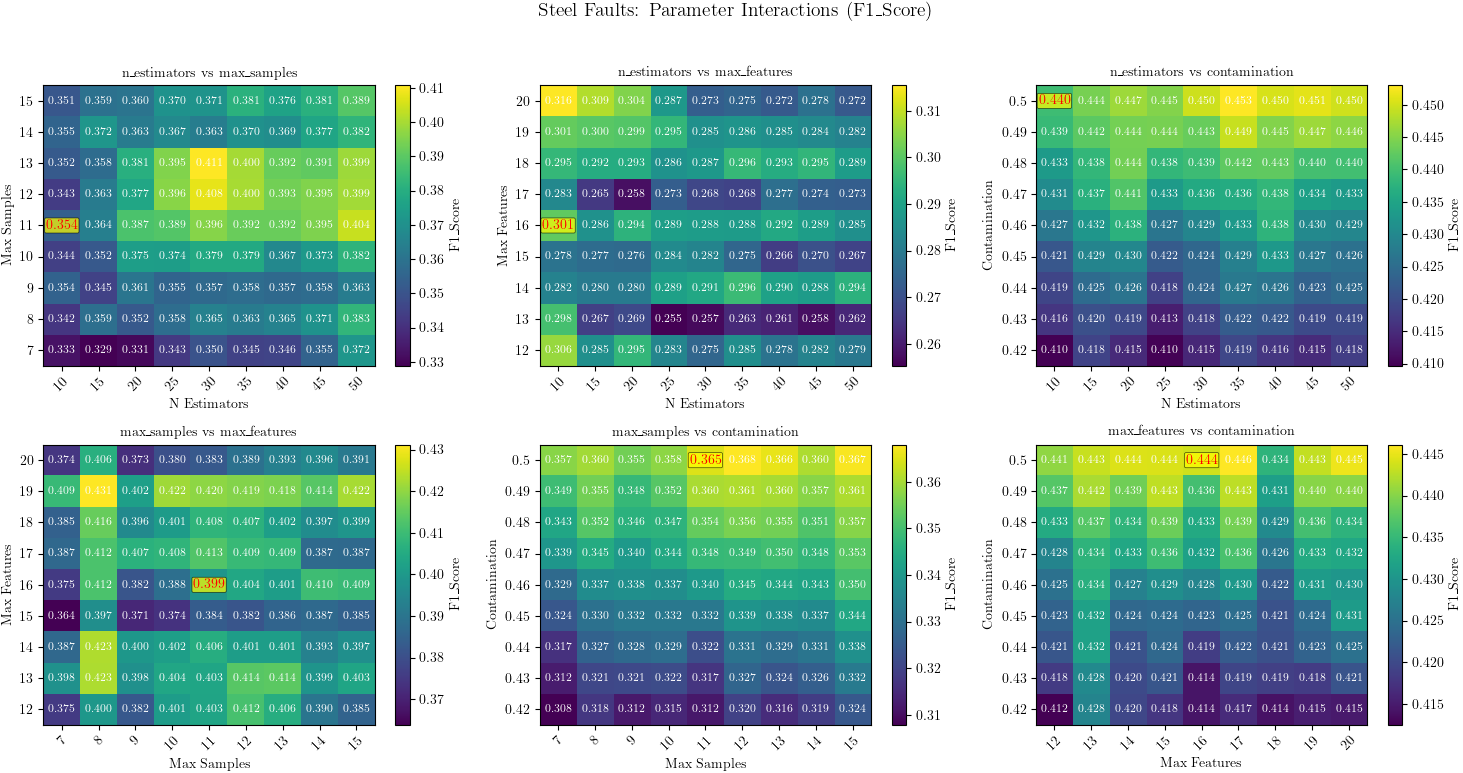

In [49]:
interaction_results_file = '../data/results/fault_interactions_results.pkl'

if os.path.exists(interaction_results_file):
    with open(interaction_results_file, 'rb') as f:
        fault_interactions = pickle.load(f)
else:
    fault_interactions = evaluate_interactions(
        X_train_fault, X_test_fault, y_test_fault,
        fault_n_estimators_results, fault_max_samples_results, 
        fault_max_features_results, fault_contamination_results,
        fault_n_estimators, fault_max_samples, 
        fault_max_features, fault_contamination,
        n_runs=10, save_results=interaction_results_file
    )

# Plot interaction heatmaps
plot_parameter_interactions(fault_interactions, 'Steel Faults', metric='F1_Score', saveas='fault')

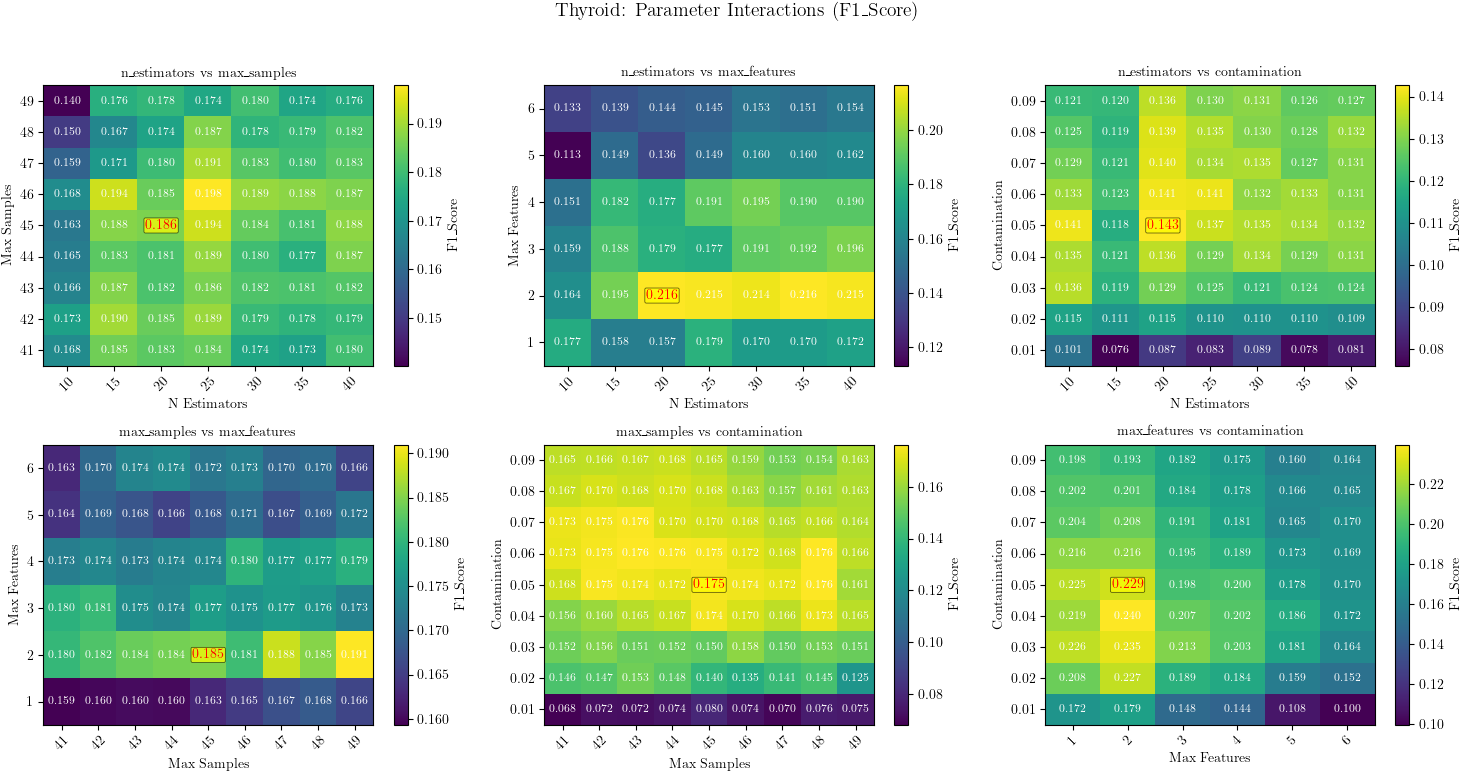

In [50]:
interaction_results_file = '../data/results/thyroid_interactions_results.pkl'

if os.path.exists(interaction_results_file):
    with open(interaction_results_file, 'rb') as f:
        thyroid_interactions = pickle.load(f)
else:
    thyroid_interactions = evaluate_interactions(
        X_train_thyroid, X_test_thyroid, y_test_thyroid,
        thyroid_n_estimators_results, thyroid_max_samples_results, 
        thyroid_max_features_results, thyroid_contamination_results,
        thyroid_n_estimators, thyroid_max_samples, 
        thyroid_max_features, thyroid_contamination,
        n_runs=10, save_results=interaction_results_file
    )

# Plot interaction heatmaps
plot_parameter_interactions(thyroid_interactions, 'Thyroid', metric='F1_Score', saveas='thyroid')

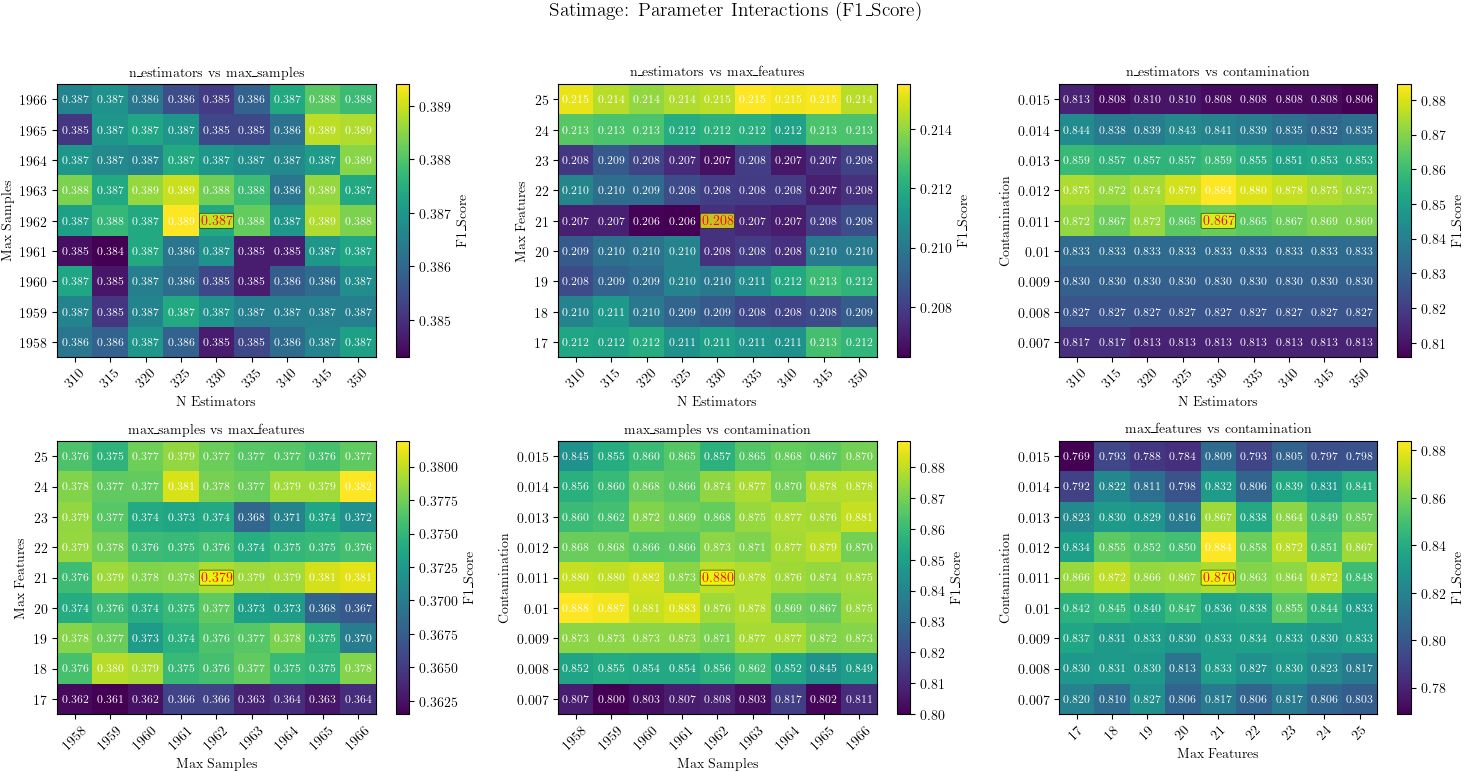

In [51]:
interaction_results_file = '../data/results/sat_interactions_results.pkl'

if os.path.exists(interaction_results_file):
    with open(interaction_results_file, 'rb') as f:
        sat_interactions = pickle.load(f)
else:
    sat_interactions = evaluate_interactions(
        X_train_sat, X_test_sat, y_test_sat,
        sat_n_estimators_results, sat_max_samples_results, 
        sat_max_features_results, sat_contamination_results,
        sat_n_estimators, sat_max_samples, 
        sat_max_features, sat_contamination,
        n_runs=10, save_results=interaction_results_file
    )

# Plot interaction heatmaps
plot_parameter_interactions(sat_interactions, 'Satimage', metric='F1_Score', saveas='sat')

In [68]:
def compute_interaction_correlation_matrix_simple(interaction_results):
    """
    Simplified approach: compute correlation matrix for parameter interactions and F1 scores
    """
    # Collect data for each interaction type
    interaction_data = {
        'F1_Score': [],
        'n_estimators_x_max_samples': [],
        'n_estimators_x_max_features': [], 
        'n_estimators_x_contamination': [],
        'max_samples_x_max_features': [],
        'max_samples_x_contamination': [],
        'max_features_x_contamination': []
    }
    
    # Process each interaction result
    for interaction_name, data in interaction_results.items():
        param1 = data['param1']
        param2 = data['param2']
        avg_results = data['avg_results']
        
        # Determine which interaction column this corresponds to
        interaction_key = f"{param1}_x_{param2}"
        if interaction_key not in interaction_data:
            interaction_key = f"{param2}_x_{param1}"  # Try reverse order
        
        if interaction_key in interaction_data:
            for _, row in avg_results.iterrows():
                # Add F1 score
                interaction_data['F1_Score'].append(row['F1_Score_mean'])
                
                # Calculate multiplicative interaction
                multiplicative_interaction = row[param1] * row[param2]
                
                # Add to appropriate interaction column
                for key in interaction_data.keys():
                    if key == 'F1_Score':
                        continue
                    elif key == interaction_key:
                        interaction_data[key].append(multiplicative_interaction)
                    else:
                        interaction_data[key].append(0)  # Fill with 0 for other interactions
    
    # Convert to DataFrame and compute correlation
    df = pd.DataFrame(interaction_data)
    
    # Remove rows where all interaction values are 0
    interaction_cols = [col for col in df.columns if col != 'F1_Score']
    mask = (df[interaction_cols] != 0).any(axis=1)
    df_filtered = df[mask]
    
    # Get F1 correlations with interactions only
    corr_matrix = df_filtered.corr()
    f1_correlations = corr_matrix['F1_Score'].drop('F1_Score')
    
    return f1_correlations, df_filtered

def plot_3x6_correlation_heatmap(fault_interactions, thyroid_interactions, sat_interactions, saveas=None):
    """
    Plot 3x6 correlation heatmap showing F1 correlations with parameter interactions for all 3 datasets
    """
    # Get F1 correlations for each dataset
    fault_f1_corr, _ = compute_interaction_correlation_matrix_simple(fault_interactions)
    thyroid_f1_corr, _ = compute_interaction_correlation_matrix_simple(thyroid_interactions)
    sat_f1_corr, _ = compute_interaction_correlation_matrix_simple(sat_interactions)
    
    # Create the correlation matrix (3 datasets x 6 interactions)
    datasets = ['Steel Faults', 'Thyroid', 'Satimage']
    interactions = [
        'n_estimators_x_max_samples',
        'n_estimators_x_max_features', 
        'n_estimators_x_contamination',
        'max_samples_x_max_features',
        'max_samples_x_contamination',
        'max_features_x_contamination'
    ]
    
    # Create correlation matrix
    correlation_matrix = np.zeros((3, 6))
    
    # Fill in correlations for each dataset
    for i, f1_corr in enumerate([fault_f1_corr, thyroid_f1_corr, sat_f1_corr]):
        for j, interaction in enumerate(interactions):
            if interaction in f1_corr.index:
                correlation_matrix[i, j] = f1_corr[interaction]
            else:
                correlation_matrix[i, j] = 0
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create heatmap
    im = plt.imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks and labels
    plt.xticks(range(len(interactions)), 
               [interaction.replace('_x_', ' × ').replace('_', ' ').title() for interaction in interactions], 
               rotation=45, ha='right')
    plt.yticks(range(len(datasets)), datasets)
    
    # Add colorbar
    plt.colorbar(im, label='Correlation with F1 Score')
    
    # Add correlation values as text
    for i in range(len(datasets)):
        for j in range(len(interactions)):
            value = correlation_matrix[i, j]
            color = 'white' if abs(value) > 0.5 else 'black'
            plt.text(j, i, f'{value:.3f}', ha='center', va='center', 
                    color=color, fontsize=10, fontweight='bold')
    
    plt.title('Parameter Interaction Correlations with F1 Score Across Datasets', fontsize=14, pad=20)
    plt.xlabel('Parameter Interactions', fontsize=12)
    plt.ylabel('Datasets', fontsize=12)
    plt.tight_layout()
    
    if saveas:
        plt.savefig(f"../report/plots/{saveas}.pdf", 
                   dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix, datasets, interactions

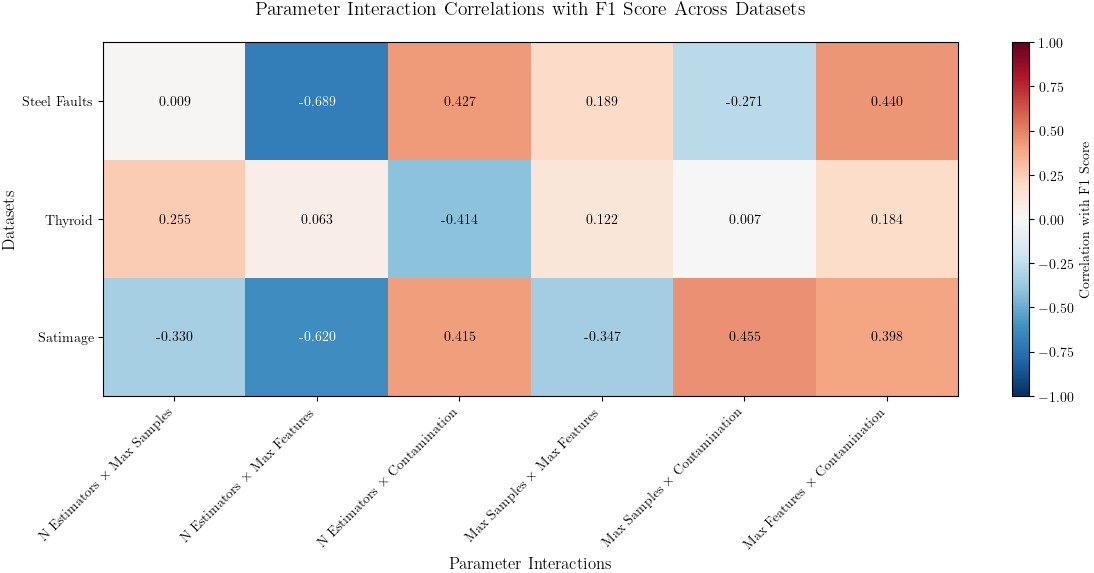

In [69]:
# Create 3x6 correlation heatmap
correlation_matrix, datasets, interactions = plot_3x6_correlation_heatmap(
    fault_interactions, thyroid_interactions, sat_interactions, saveas="interactions_correlations"
)